# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета. 

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Продуктивной и интересной вам работы!

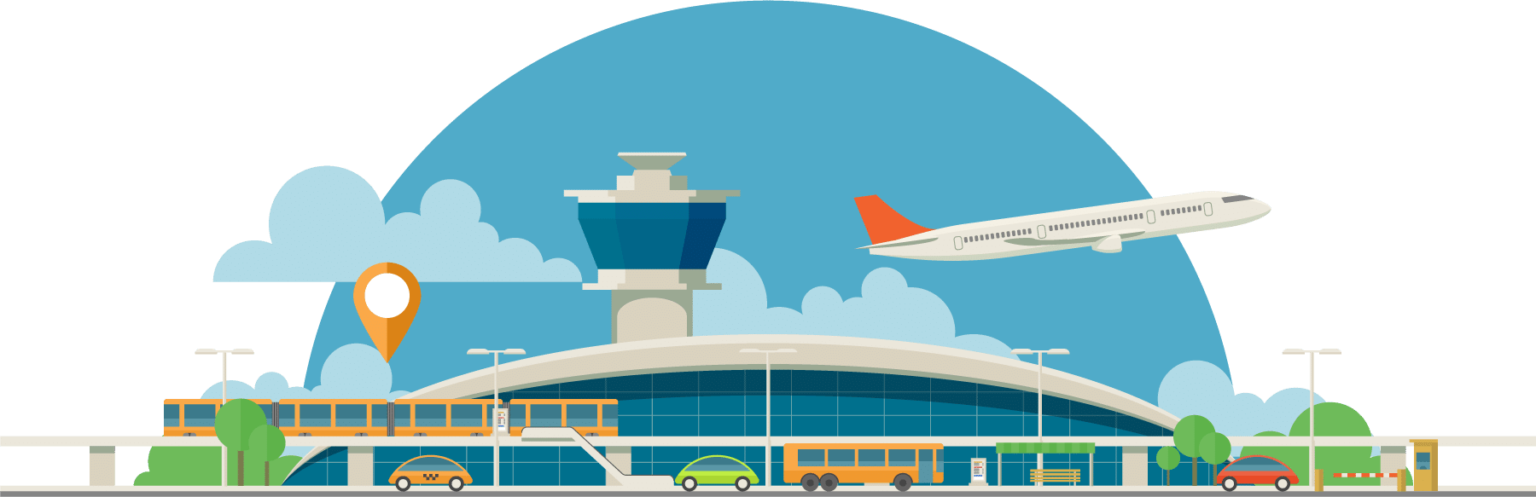

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода. <br/> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [1]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

  Obtaining dependency information for mlxtend from https://files.pythonhosted.org/packages/73/da/d5d77a9a7a135c948dbf8d3b873655b105a152d69e590150c83d23c3d070/mlxtend-0.23.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.5 MB/s eta 0:00:00a 0:00:010m
  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/4c/6a/219a431aaf81b3eb3070fd2d58116baa366d3072f43bbcc87dc3495b7546/optuna-3.5.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for scikit-image>=0.12 from https://files.pythonhosted.org/packages/9f/d9/dc99e527d1a0050f0353d2fff3548273b4df6151884806e324f26572fd6b/scikit_image-0.22.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for networkx>=2.8 from http

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions 
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data Prep & EDA (3 балла)

## Загрузка и предобработка данных (1.75 балла)

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

/bin/sh: wget: command not found


(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycopg2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно. 

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

### Схема БД

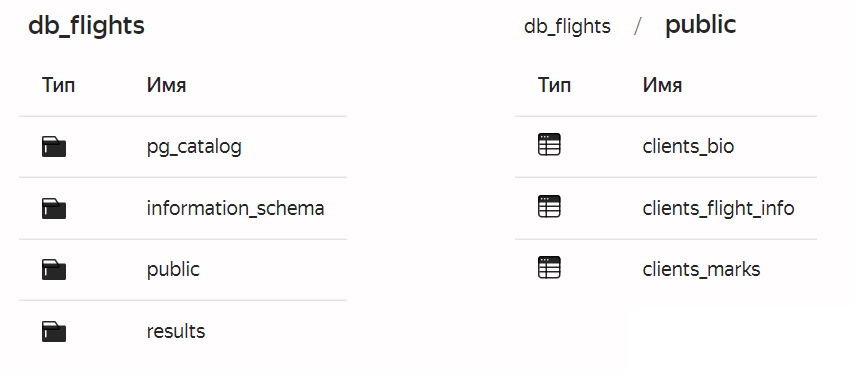

In [4]:
try:
    # Подключение к базе данных
    conn = psycopg2.connect(
        host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
        port=6432,
        database="db_flights",
        user="mlhs_student",
        password="mlhs_student",
        target_session_attrs="read-write"
    )

    # Создание курсора
    cur = conn.cursor()

    # Выполнение SQL-запроса
    cur.execute('''
    SELECT *
    FROM public.clients_bio CB
        LEFT JOIN public.clients_flight_info CFI ON CB.id = CFI.id
        LEFT JOIN public.clients_marks CM ON CB.id = CM.id
    ''')
    
    # Получение результатов
    table = cur.fetchall()
    
    column_names = [desc[0] for desc in cur.description]
    
    df = pd.DataFrame(table, columns=column_names)
    df = df.loc[:, ~df.columns.duplicated()]
    df = df.set_index('id')
finally:
    # Закроем подключение
    if conn:
        conn.close()

In [5]:
assert df.shape == (129_549, 23)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [6]:
pd.set_option('display.max_columns', 23)

In [7]:
# Уберу пробелы из названия столбцов
col_nm = pd.Series(df.columns).apply(lambda x: x.replace(' ', '_'))
df.columns = col_nm

In [8]:
df.head()

gender   age      Customer_Type   Type_of_Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight_Distance Departure_Delay_in_Minutes Arrival_Delay_in_Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight_wifi_service Departure/Arrival_time_convenient  \
id                                                           
7                    3.0                               3.0   
13                   2.0                               2.0   
18                   2.0                               5.0   
31                   2.0                               2.0   
39                   3.0                               3.0   

   Ease_of_Online_booking Gate_location Food_and_drink Online_boarding  \
id                                                                       
7                     3.0           3.0            5.0             4.0   
13                    2.0           4.0            5.0             2.0   
18                    2.0           1.0            4.0             1.0   
31                    2.0           1.0            2.0             2.0   
39                    3.0           3.0            4.0             5.0   

   Seat_comfort Inflight_entertainment On-board_service Leg_room_service  \
id                                                                         
7           5.0                    5.0              5.0              5.0   
13          5.0                    5.0              2.0              4.0   
18          5.0                    5.0              5.0              2.0   
31          2.0                    2.0              4.0              5.0   
39          4.0                    4.0              4.0              4.0   

   Baggage_handling Checkin_service Inflight_service cleanliness  \
id                                                                 
7               5.0             4.0              5.0         4.0   
13              4.0             2.0              4.0         5.0   
18              5.0             5.0              5.0         1.0   
31              5.0             5.0              4.0         2.0   
39              4.0             5.0              4.0         5.0   

               satisfaction  
id                           
7                 satisfied  
13  neutral or dissatisfied  
18  neutral or dissatisfied  
31  neutral or dissatisfied  
39                satisfied

In [9]:
numeric_cols = [
    'age', 'Flight_Distance', 'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes', 'Inflight_wifi_service', 
    'Departure/Arrival_time_convenient', 'Ease_of_Online_booking', 'Gate_location',	'Food_and_drink', 'Online_boarding', 
    'Seat_comfort', 'Inflight_entertainment', 'On-board_service', 'Leg_room_service', 'Baggage_handling', 'Checkin_service', 'Inflight_service', 'cleanliness'
]

df[numeric_cols] = df[numeric_cols].astype('float64')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer_Type                      129549 non-null  object 
 3   Type_of_Travel                     129549 non-null  object 
 4   class                              129549 non-null  object 
 5   Flight_Distance                    129455 non-null  float64
 6   Departure_Delay_in_Minutes         129442 non-null  float64
 7   Arrival_Delay_in_Minutes           129042 non-null  float64
 8   Inflight_wifi_service              129505 non-null  float64
 9   Departure/Arrival_time_convenient  129500 non-null  float64
 10  Ease_of_Online_booking             129506 non-null  float64
 11  Gate_location                      129512 no

(0.5 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

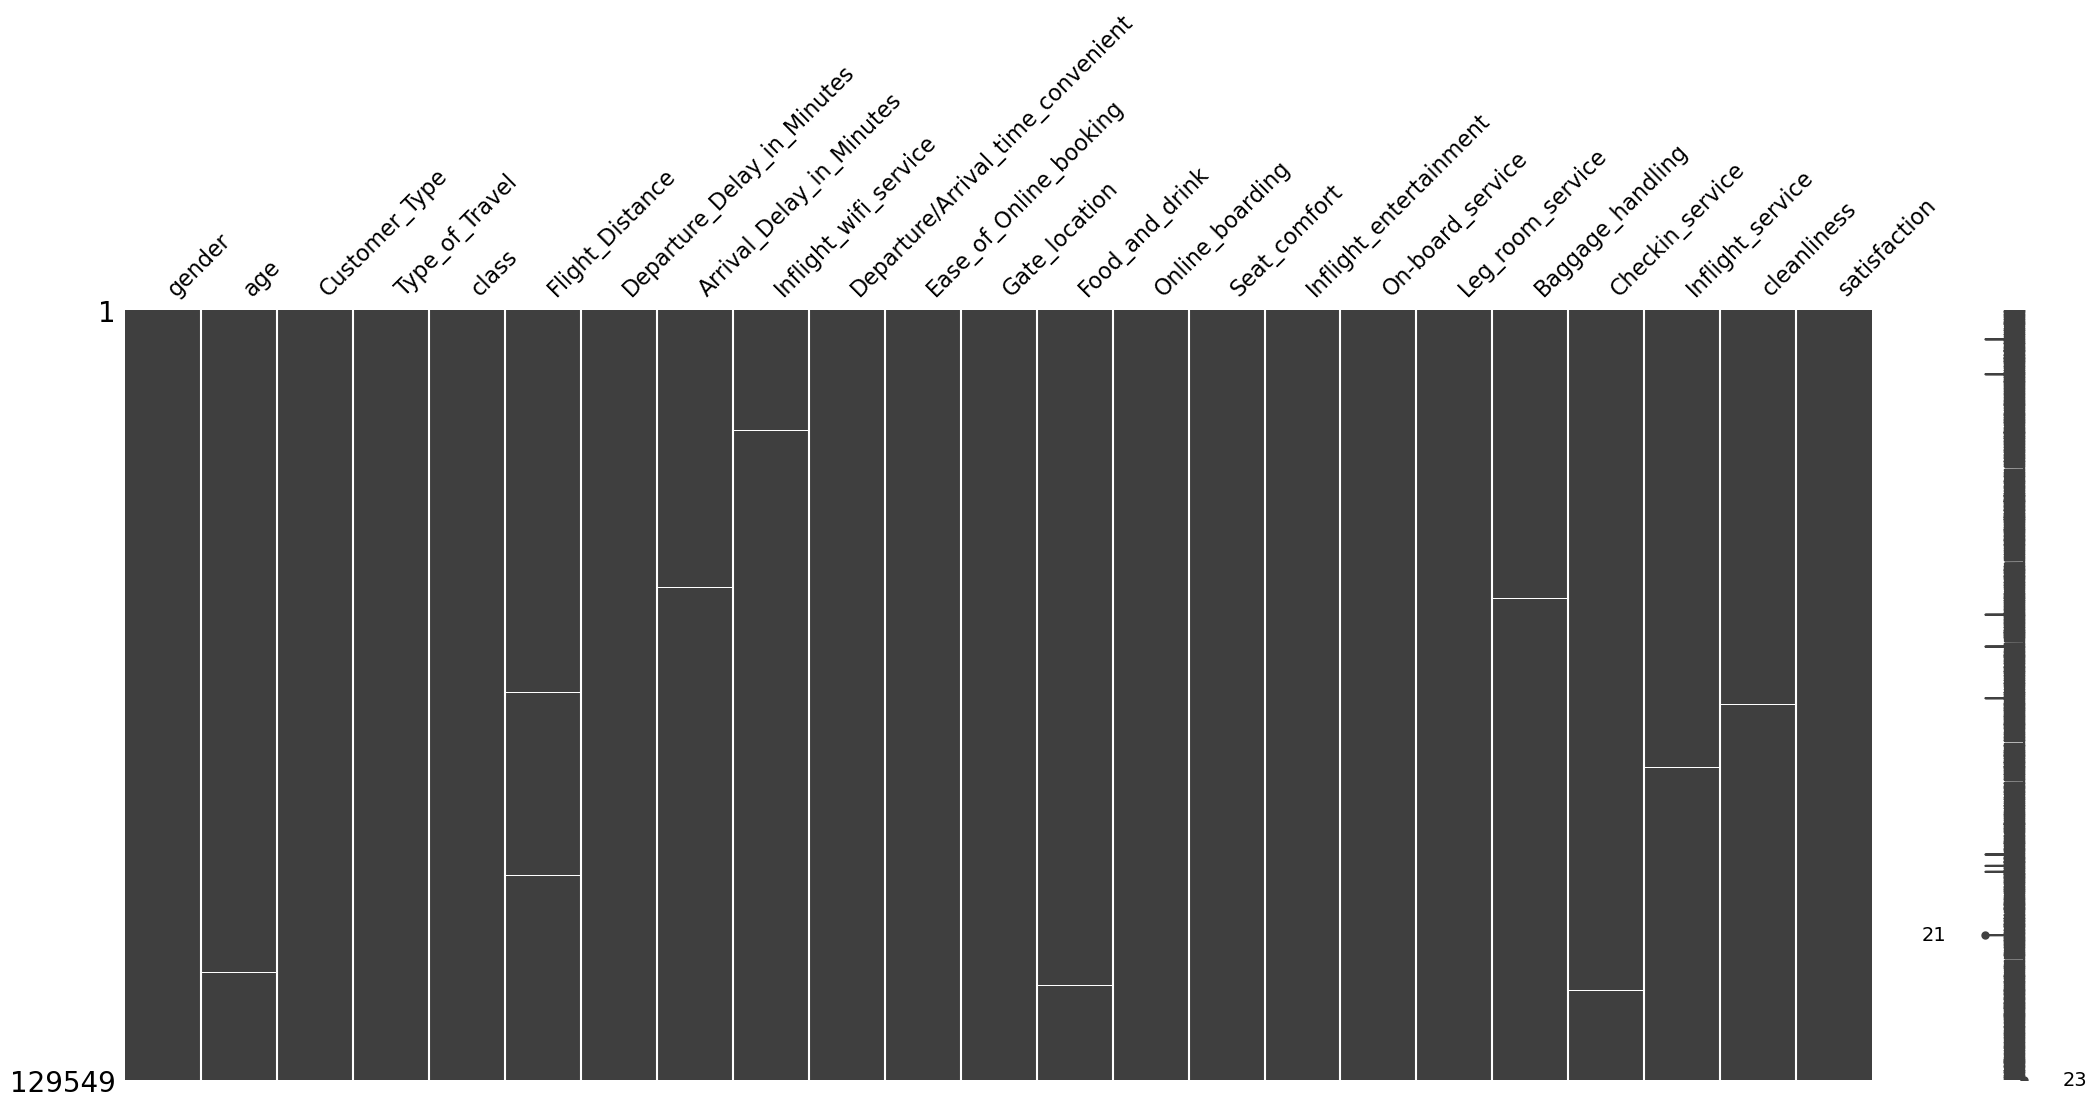

In [11]:
missingno.matrix(df)

plt.show()

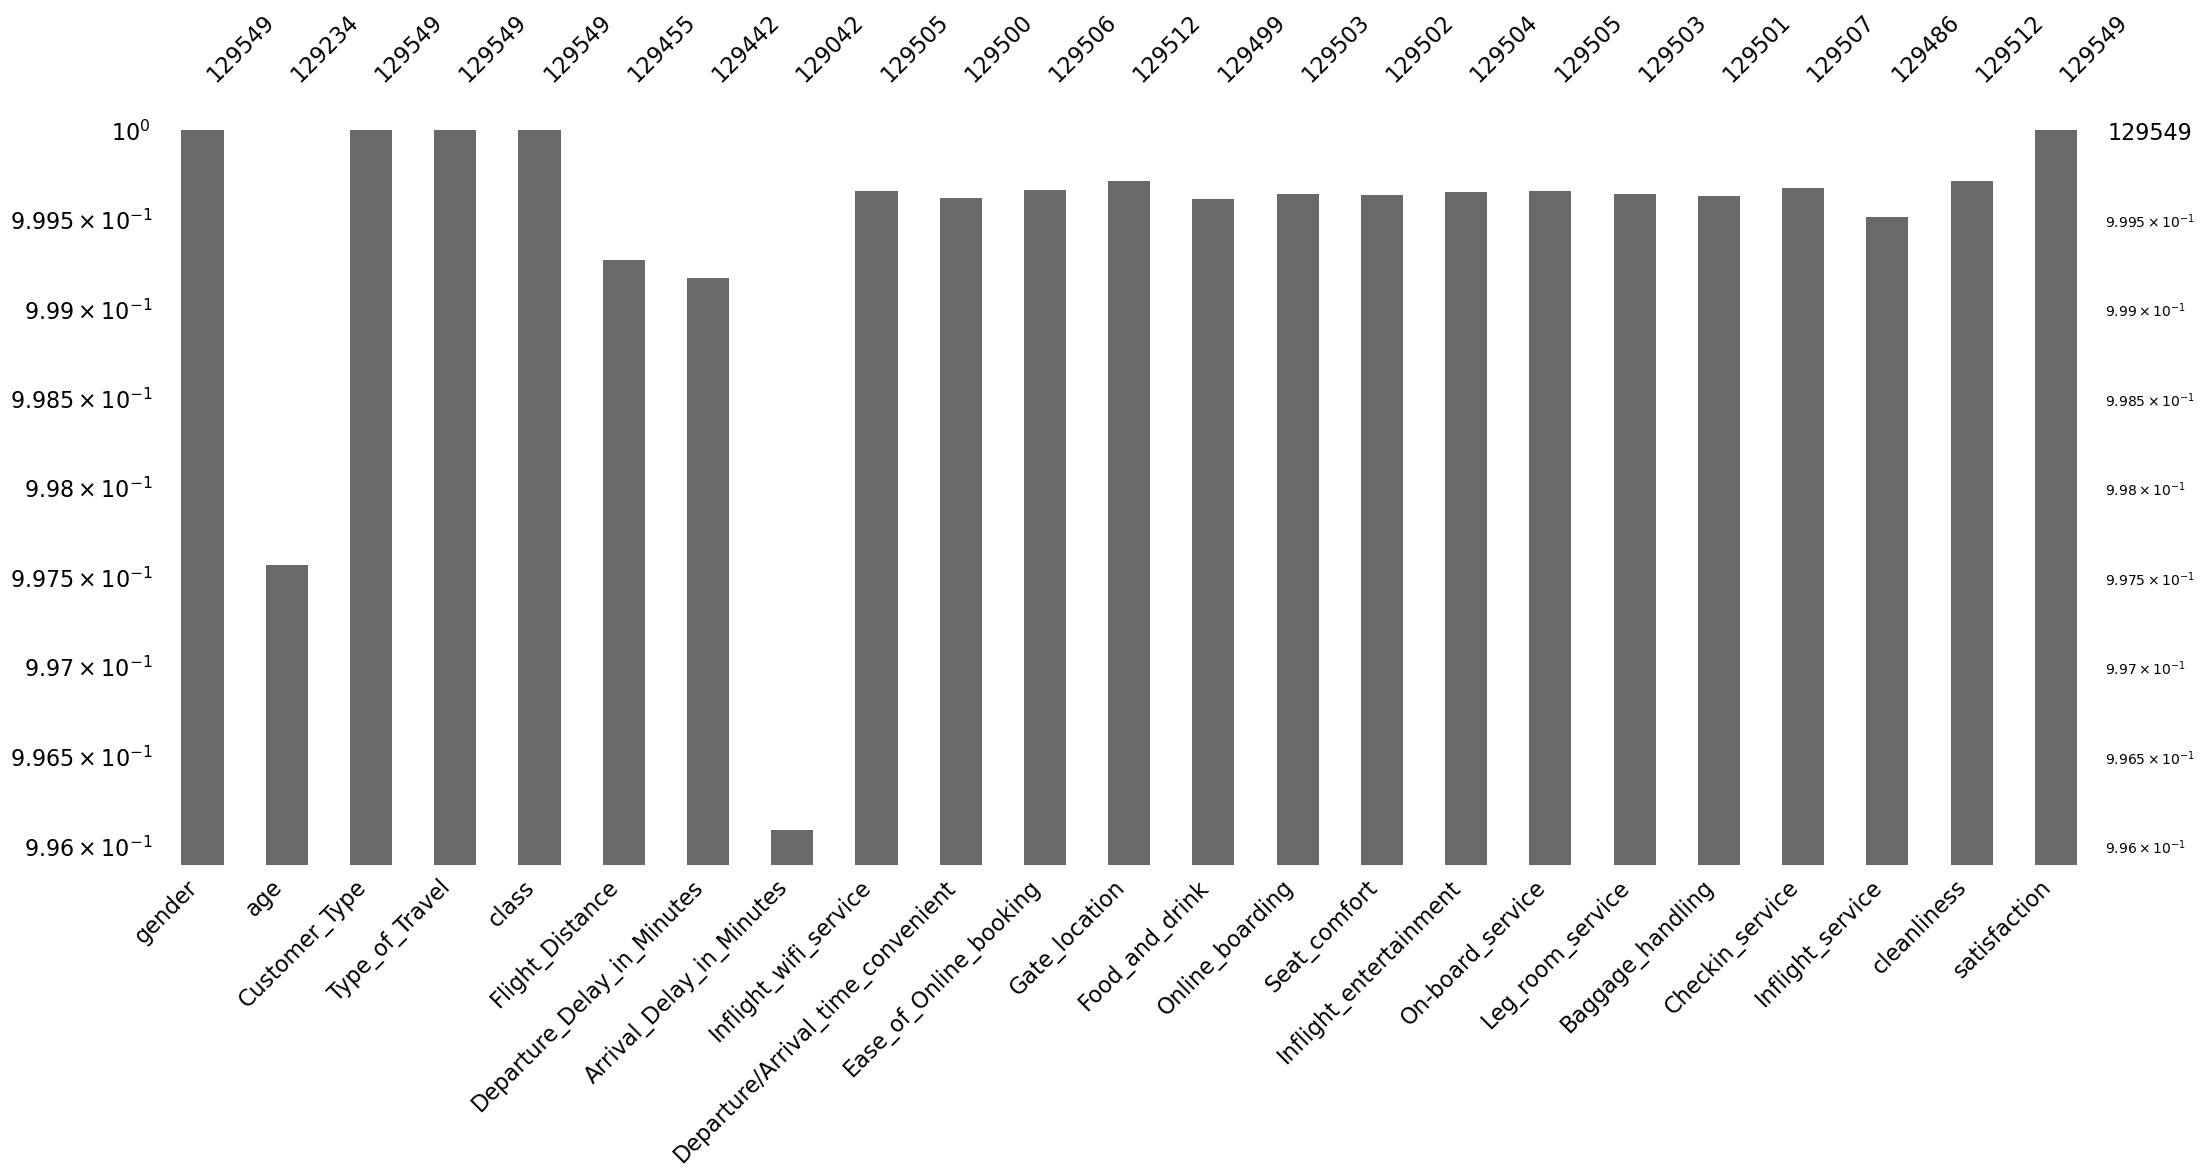

In [12]:
missingno.bar(df, log=True)

plt.show()

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [13]:
df_train = df[df.satisfaction != '-']
df_train.head()

gender   age      Customer_Type   Type_of_Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

    Flight_Distance  Departure_Delay_in_Minutes  Arrival_Delay_in_Minutes  \
id                                                                          
7            1963.0                         0.0                       0.0   
13            453.0                        16.0                      30.0   
18            821.0                         0.0                       0.0   
31            212.0                         0.0                       0.0   
39             67.0                         0.0                       0.0   

    Inflight_wifi_service  Departure/Arrival_time_convenient  \
id                                                             
7                     3.0                                3.0   
13                    2.0                                2.0   
18                    2.0                                5.0   
31                    2.0                                2.0   
39                    3.0                                3.0   

    Ease_of_Online_booking  Gate_location  Food_and_drink  Online_boarding  \
id                                                                           
7                      3.0            3.0             5.0              4.0   
13                     2.0            4.0             5.0              2.0   
18                     2.0            1.0             4.0              1.0   
31                     2.0            1.0             2.0              2.0   
39                     3.0            3.0             4.0              5.0   

    Seat_comfort  Inflight_entertainment  On-board_service  Leg_room_service  \
id                                                                             
7            5.0                     5.0               5.0               5.0   
13           5.0                     5.0               2.0               4.0   
18           5.0                     5.0               5.0               2.0   
31           2.0                     2.0               4.0               5.0   
39           4.0                     4.0               4.0               4.0   

    Baggage_handling  Checkin_service  Inflight_service  cleanliness  \
id                                                                     
7                5.0              4.0               5.0          4.0   
13               4.0              2.0               4.0          5.0   
18               5.0              5.0               5.0          1.0   
31               5.0              5.0               4.0          2.0   
39               4.0              5.0               4.0          5.0   

               satisfaction  
id                           
7                 satisfied  
13  neutral or dissatisfied  
18  neutral or dissatisfied  
31  neutral or dissatisfied  
39                satisfied

In [14]:
assert df_train.shape == (103_644, 23)

In [15]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

gender   age   Customer_Type   Type_of_Travel     class  Flight_Distance  \
id                                                                              
55     Male  36.0  Loyal Customer  Business travel  Business           3655.0   
79   Female  70.0  Loyal Customer  Personal Travel       Eco            108.0   
126    Male  66.0  Loyal Customer  Personal Travel       Eco            562.0   
199  Female  60.0  Loyal Customer  Business travel  Business           3756.0   
263    Male  43.0  Loyal Customer  Personal Travel  Business            802.0   

     Departure_Delay_in_Minutes  Arrival_Delay_in_Minutes  \
id                                                          
55                         40.0                      71.0   
79                         50.0                      41.0   
126                        88.0                      84.0   
199                        36.0                      24.0   
263                         0.0                       0.0   

     Inflight_wifi_service  Departure/Arrival_time_convenient  \
id                                                              
55                     1.0                                1.0   
79                     5.0                                4.0   
126                    2.0                                5.0   
199                    4.0                                4.0   
263                    1.0                                2.0   

     Ease_of_Online_booking  Gate_location  Food_and_drink  Online_boarding  \
id                                                                            
55                      1.0            1.0             1.0              3.0   
79                      0.0            3.0             4.0              4.0   
126                     2.0            4.0             5.0              2.0   
199                     4.0            4.0             2.0              4.0   
263                     1.0            3.0             2.0              3.0   

     Seat_comfort  Inflight_entertainment  On-board_service  Leg_room_service  \
id                                                                              
55            3.0                     3.0               3.0               3.0   
79            4.0                     3.0               3.0               0.0   
126           5.0                     5.0               3.0               5.0   
199           5.0                     4.0               4.0               4.0   
263           3.0                     2.0               2.0               1.0   

     Baggage_handling  Checkin_service  Inflight_service  cleanliness  
id                                                                     
55                1.0              4.0               3.0          2.0  
79                3.0              5.0               3.0          5.0  
126               2.0              5.0               5.0          5.0  
199               4.0              5.0               4.0          5.0  
263               2.0              3.0               2.0          1.0

In [16]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train.drop('satisfaction', axis=1)
    , df_train.satisfaction
    , test_size=0.3
    , random_state=42
)

In [18]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые. 

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [19]:
X_train['Type_of_Travel'].value_counts()

Type_of_Travel
Business travel    49984
Personal Travel    22496
nan                   70
Name: count, dtype: int64

In [20]:
X_train['Type_of_Travel'].isna().sum()

0

In [21]:
for col in X_train.columns:
    mode_value = X_train[col].mode()[0]

    # fillna
    X_train[col] = X_train[col].fillna(mode_value)
    X_val[col] = X_val[col].fillna(mode_value)
    df_test[col] = df_test[col].fillna(mode_value)

    # Вместо str nan поставим моду
    X_train[col] = X_train[col].replace('nan', mode_value)
    X_val[col] = X_val[col].replace('nan', mode_value)
    df_test[col] = df_test[col].replace('nan', mode_value)

In [22]:
# Пропусков нет
X_train['Type_of_Travel'].value_counts()

Type_of_Travel
Business travel    50054
Personal Travel    22496
Name: count, dtype: int64

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [23]:
# Проверим налдичие пропусков
X_train.isna().sum().sum()

0

In [24]:
X_train.describe()

age  Flight_Distance  Departure_Delay_in_Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.098856      1329.018332                   15.859366   
std       20.658196      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival_Delay_in_Minutes  Inflight_wifi_service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                11760.000000              45.000000   

       Departure/Arrival_time_convenient  Ease_of_Online_booking  \
count                       72550.000000            72550.000000   
mean                            3.065017                2.761006   
std                             1.552254                1.414843   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               28.000000   

       Gate_location  Food_and_drink  Online_boarding  Seat_comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.982688        3.209318         3.256513      3.445665   
std         1.316648        1.349963         1.372739      1.346077   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       36.000000        32.000000     45.000000   

       Inflight_entertainment  On-board_service  Leg_room_service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362150          3.383101          3.352364   
std                  1.360862          1.333758          1.360180   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         36.000000   

       Baggage_handling  Checkin_service  Inflight_service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.630255         3.309056          3.640234      3.291178  
std            1.227853         1.293114          1.215114      1.343302  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

In [25]:
X_train.describe(include = 'object')

gender   Customer_Type   Type_of_Travel     class
count    72550           72550            72550     72550
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36816           59406            50054     34793

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

<Axes: >

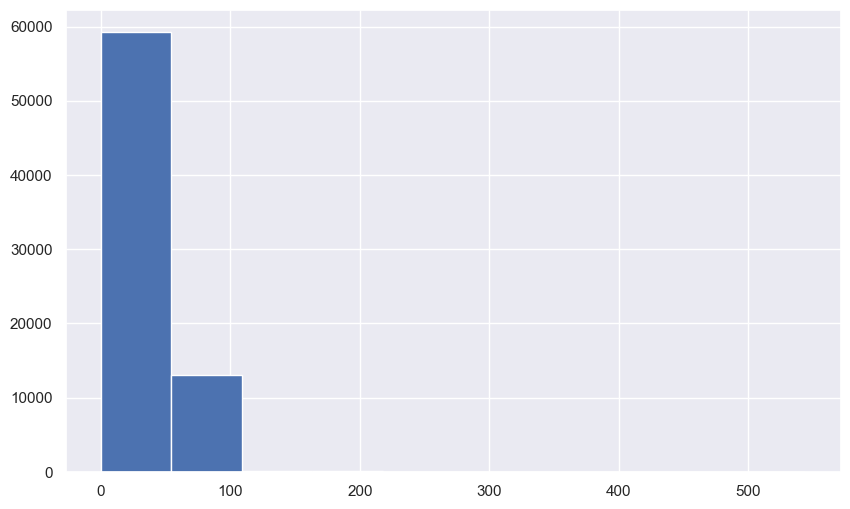

In [828]:
# Тут можно увидеть, что у нас есть хвост к 100 годам, а так же выбросы
X_train['age'].hist()

<Axes: >

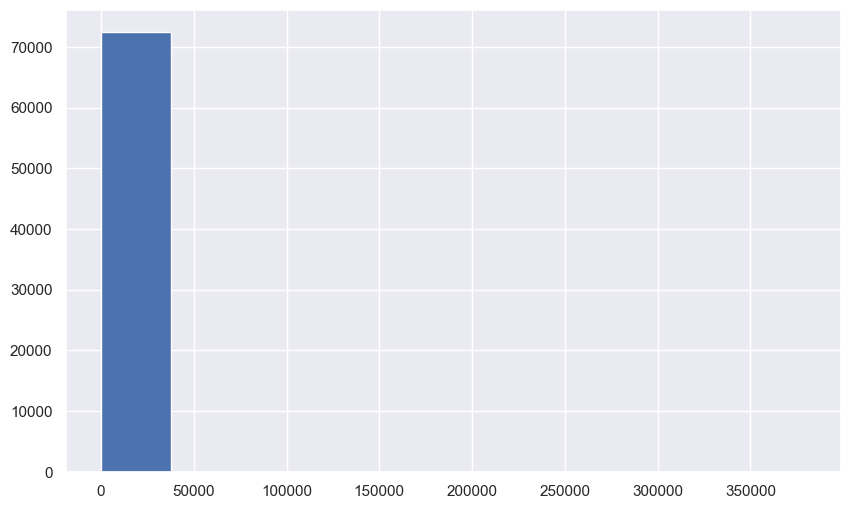

In [829]:
# Тут можно увидеть, что у нас есть огромные выбросы
X_train['Flight_Distance'].hist()

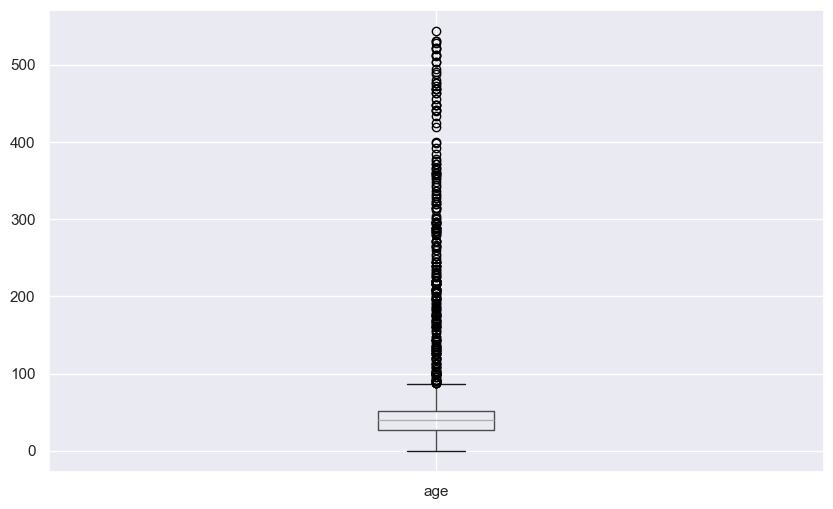

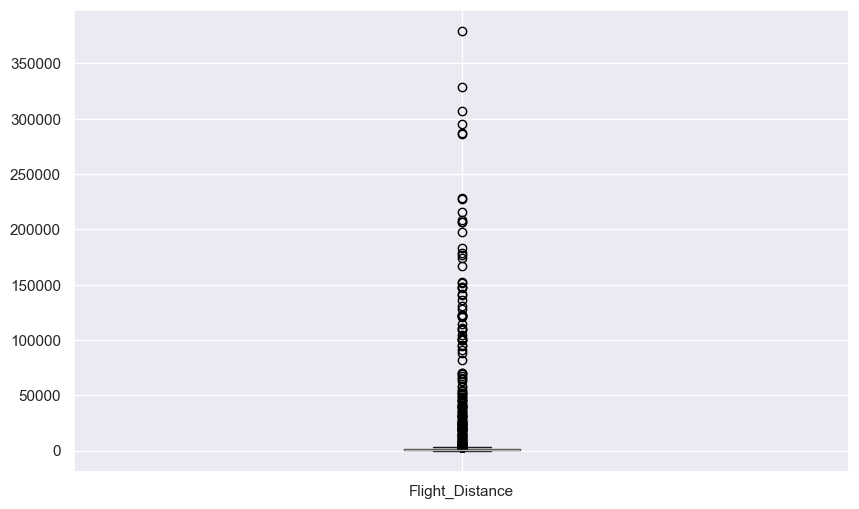

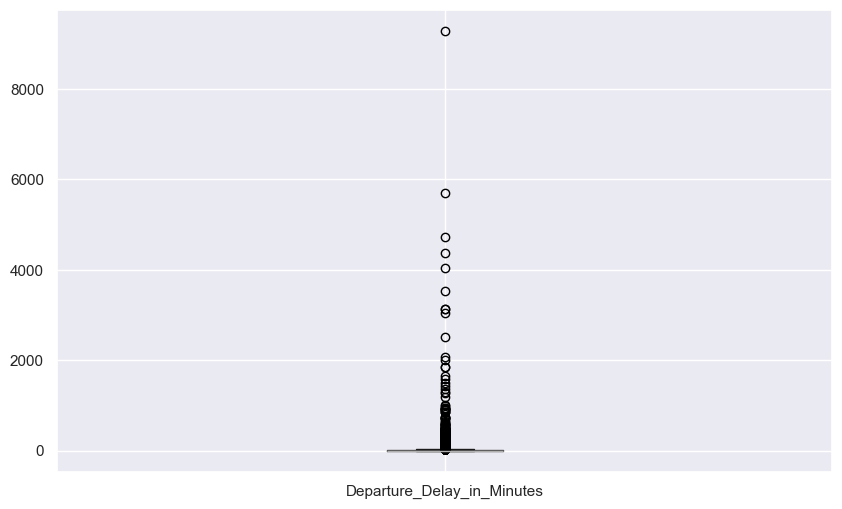

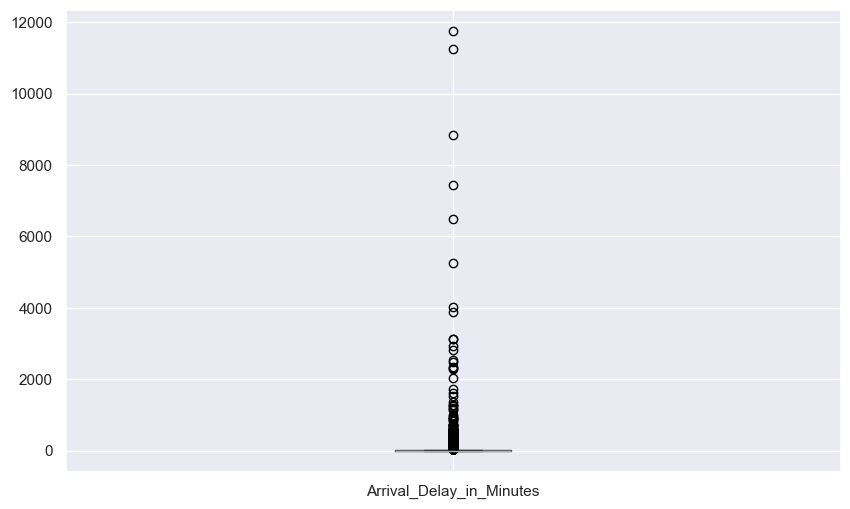

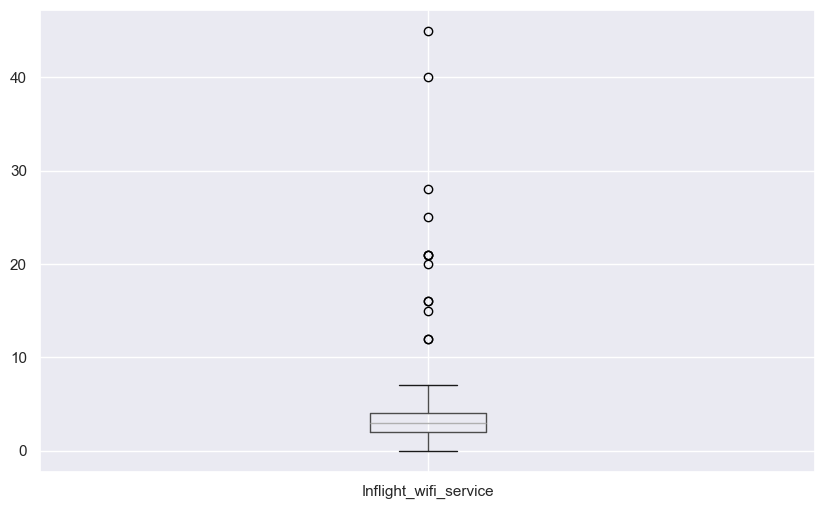

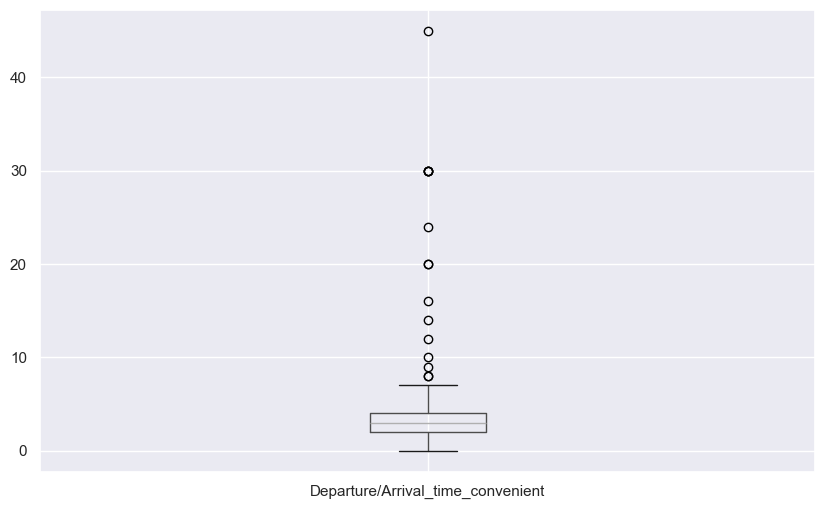

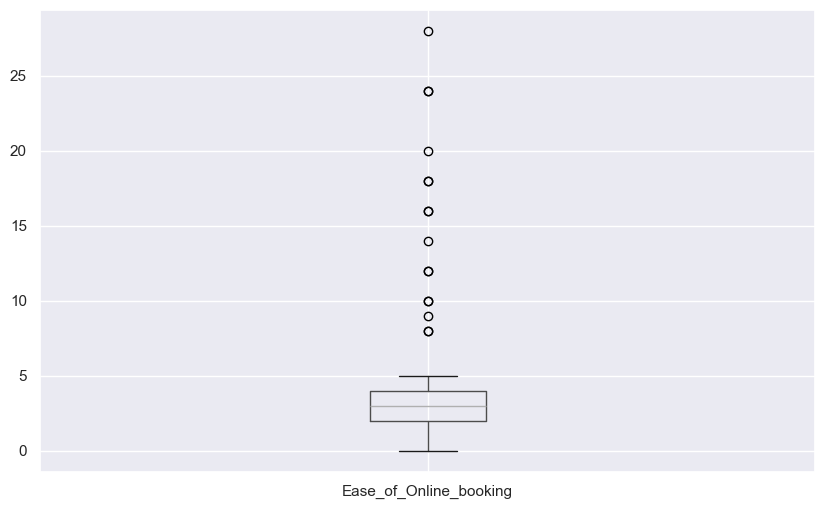

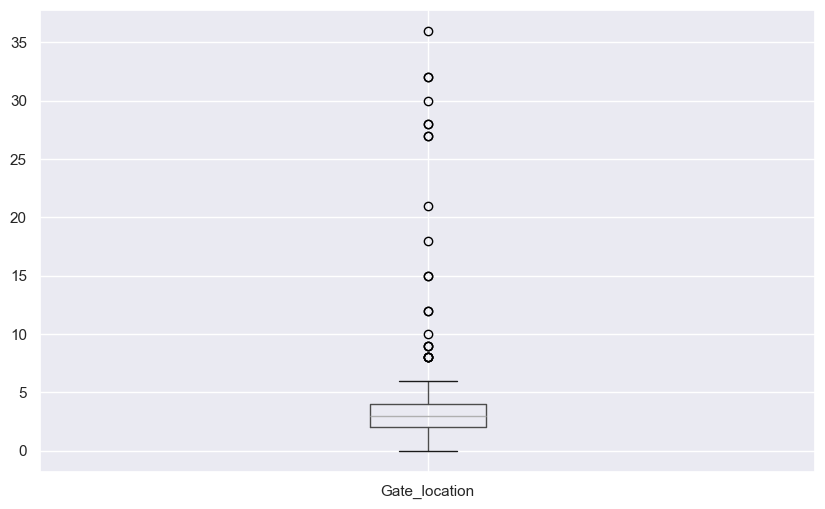

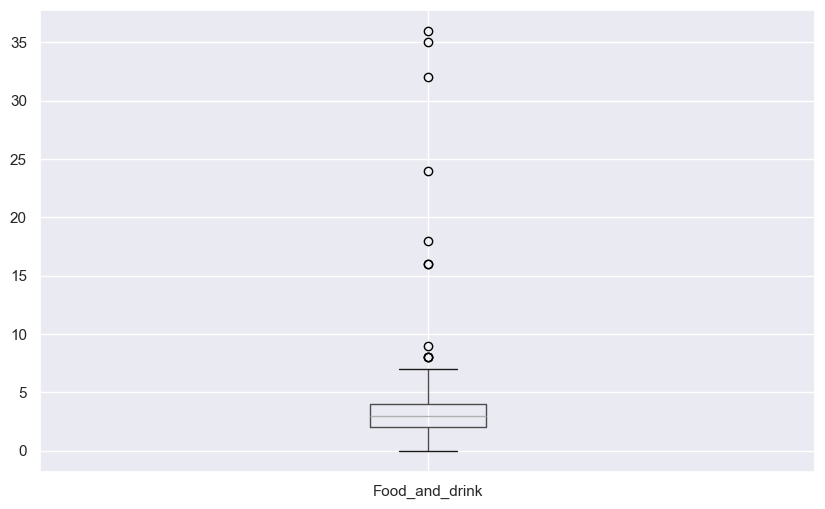

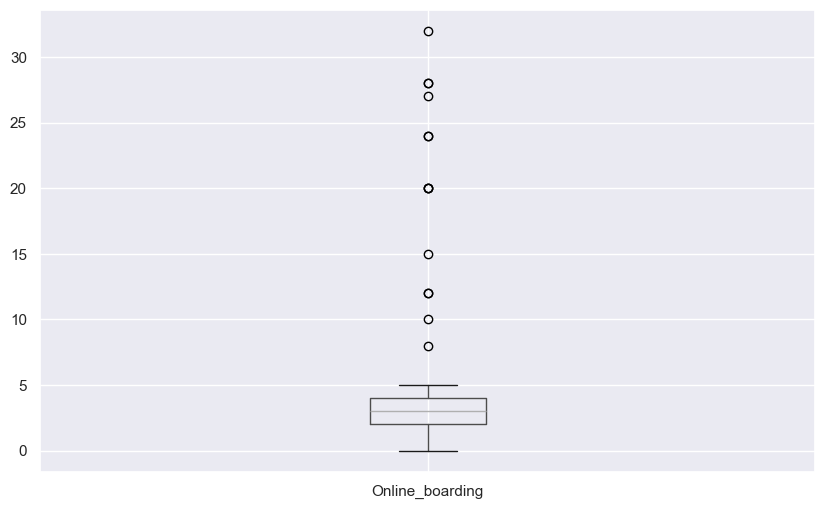

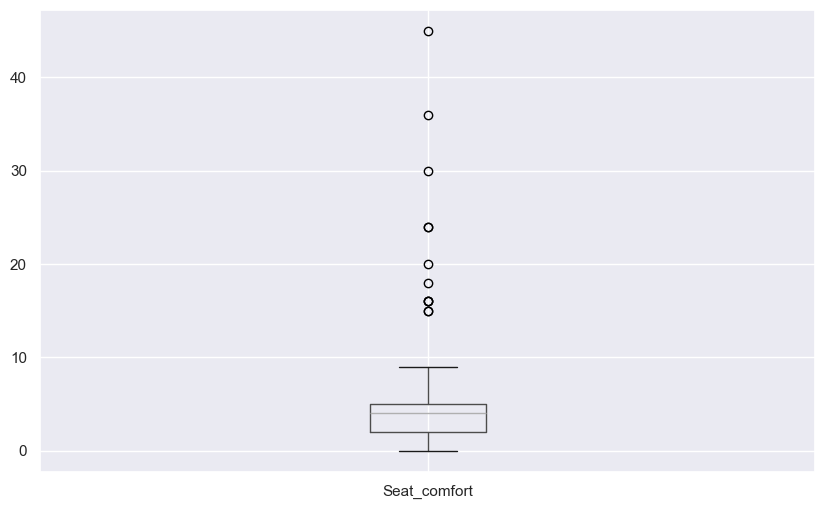

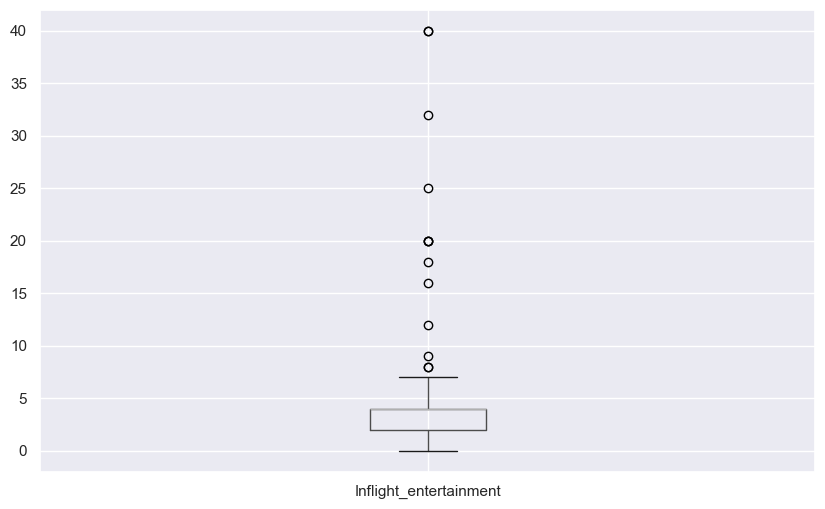

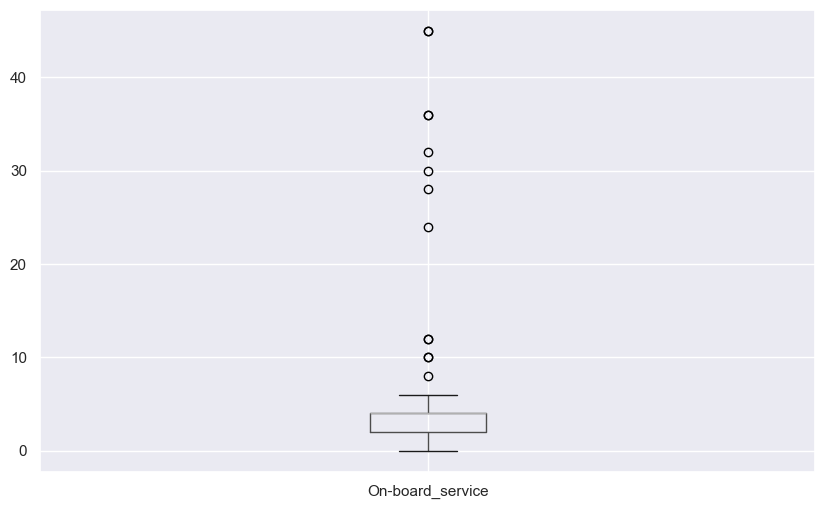

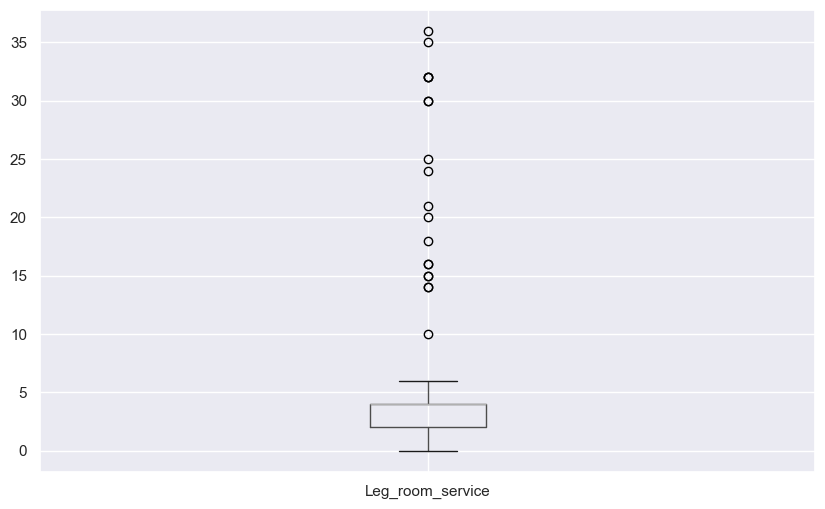

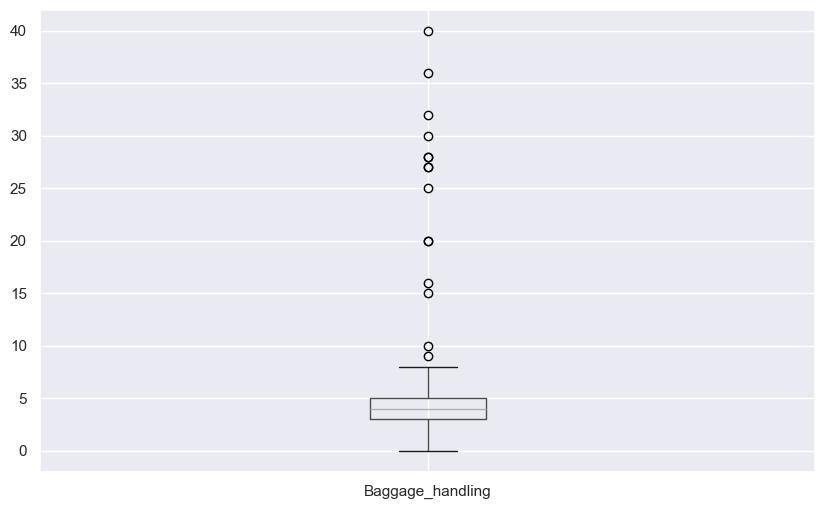

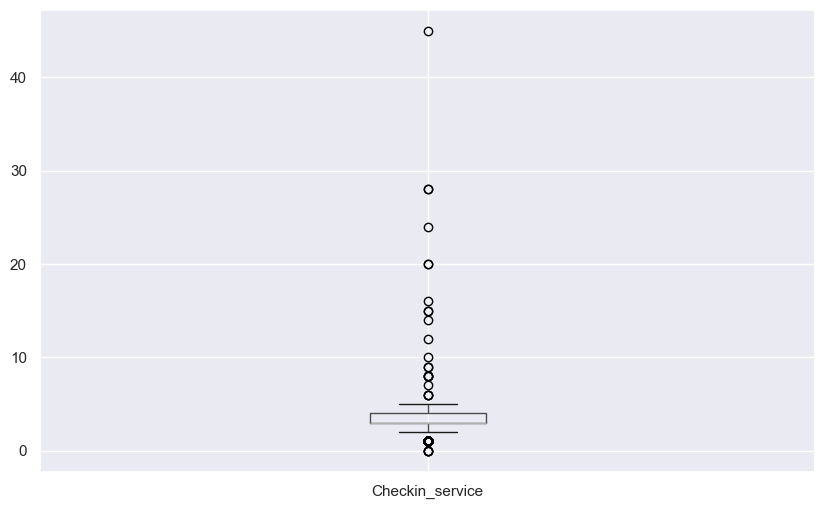

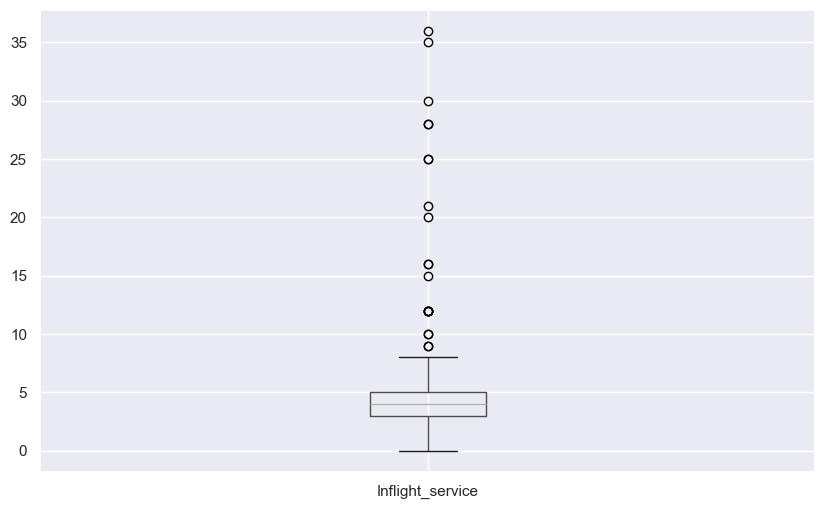

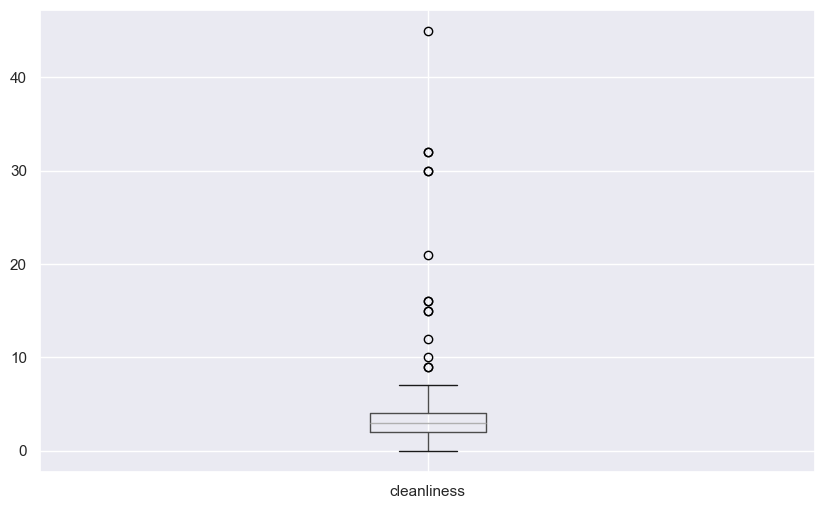

In [830]:
# boxplot
for column in numeric_cols:
   plt.figure() 
   X_train.boxplot([column]) 

plt.show() 

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах</font> (для трейна и валидации; тест оставьте без изменений). Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [26]:
# Определяем 0.996-квантиль для каждого числового столбца
for col in numeric_cols:
    # Вычисляем квантиль для столбца
    quantiles = X_train[col].quantile(0.996)

    # Удаляем строчки, где находим выброс (значение больше 0.996 квантиля)
    X_train = X_train[X_train[col] <= quantiles]
    X_val = X_val[X_val[col] <= quantiles]

In [27]:
X_train.shape, X_val.shape, 

((71175, 22), (30496, 22))

In [28]:
# из y_tarin не удалили клиентво
y_train.shape, y_val.shape, 

((72550,), (31094,))

In [29]:
# оставим нужных нам клиентов

inds = X_train.index
y_train = y_train.loc[inds]

inds = X_val.index
y_val = y_val.loc[inds]

In [30]:
assert X_train.shape[0] == y_train.shape[0]

In [31]:
assert X_val.shape[0] == y_val.shape[0]

In [32]:
# assert X_train.shape == (71_369, 22) эти ассерты у большинства студентов не проходили
# assert X_val.shape == (30_609, 22) и это совершенно не принципиально
assert df_test.shape == (25_905, 22)

## EDA (1.25 балла)

Создадим переменные с перечислениями столбцов разного типа

In [33]:
continuous_cols = ['age', 'Flight_Distance', 'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols)) 
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [34]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [846]:
def plot_ordinal(df, y, cols=ordinal_cols, y_name='satisfaction'):
    """Draws countplots for all columns in 'cols' with informative title"""
    # Объединим данные
    full_train = pd.concat([df, y], axis=1)

    for col in cols:
    
        plt.figure(figsize=(9, 6))

        # Представленые в задача графики ограничены значением 5 (как я понял(=). 
        # Без ограничения будет большой хвост в распределении
        iter_df = full_train[full_train[col]<=5]
        
        sns.countplot(iter_df, x=col , hue=y_name)
    
        plt.title(f'{col} distribution')
    
        plt.show()


In [847]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row 
    for all columns in 'cols' with informative title 
    """
    cnt_continuous_cols = len(continuous_cols)
    
    for i in range(cnt_continuous_cols):
        # Пройдем по каждой колонки и нарисуем график
        fig, ax = plt.subplots(1,2, figsize=(12, 4))
    
        col = continuous_cols[i]
        
        # Создаем гистограмму
        sns.kdeplot(x=X_train[col], hue=y_train, ax=ax[0]).set_title(f"{col} ditribution")
        
        # Создаем ящик с усами
        sns.boxplot(x=X_train[col], y=y_train, hue=y_train, ax=ax[1]).set_title(f"{col} boxplot by target")
    
        plt.show()

In [848]:
def plot_categorical(df, y, cols=categorical_cols):

    for col in cols:
        plt.figure(figsize=(8, 6))
        
        sns.countplot(df, x=col, hue=y) 
        
        plt.title(f'{col} distribution')
        
        plt.show()    

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

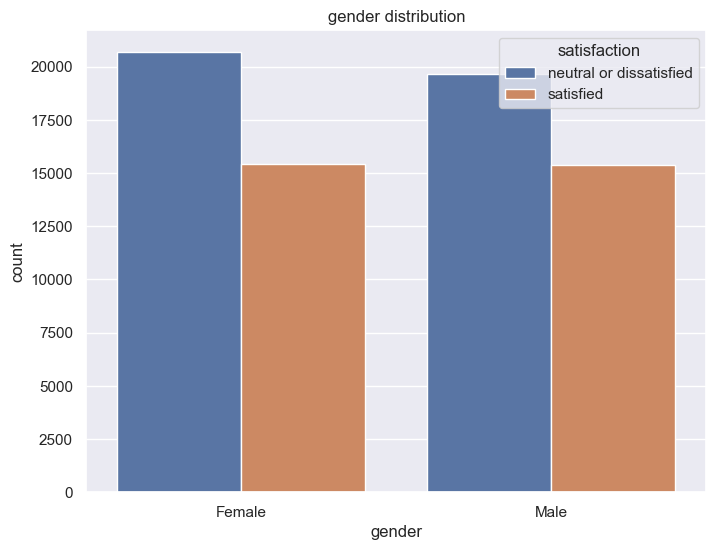

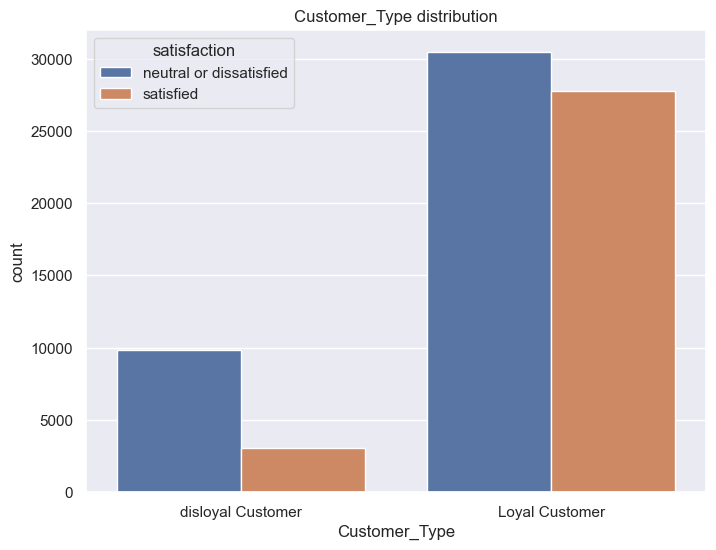

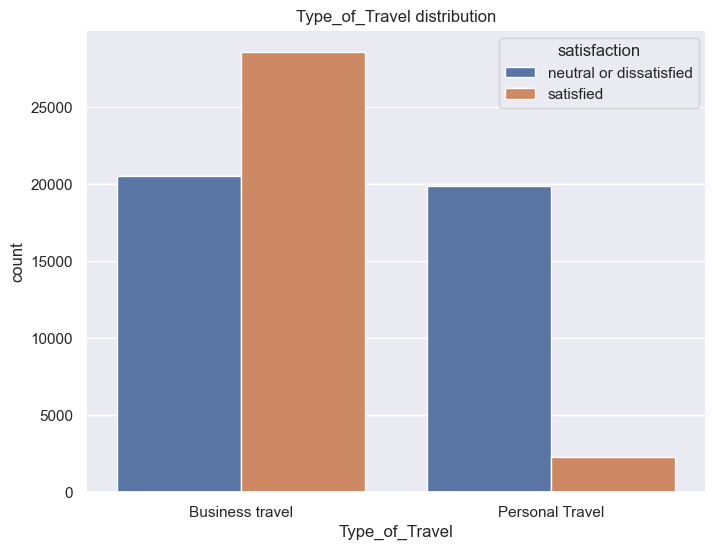

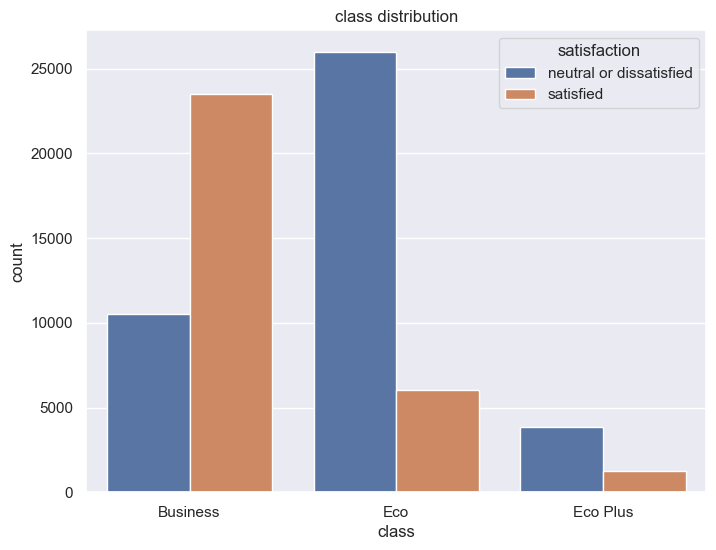

In [849]:
# Категориальные переменные
plot_categorical(X_train, y_train)

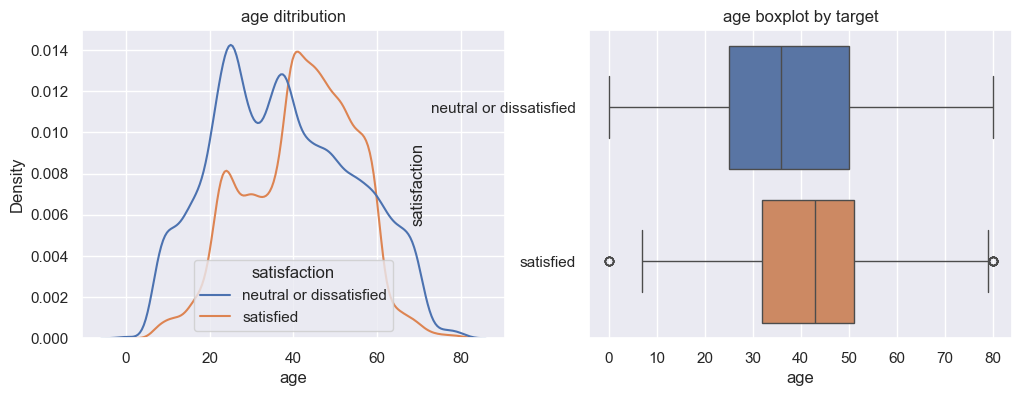

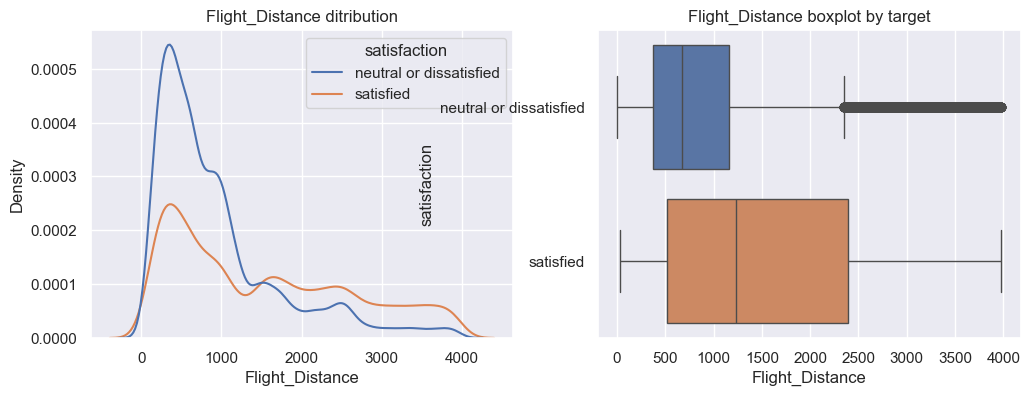

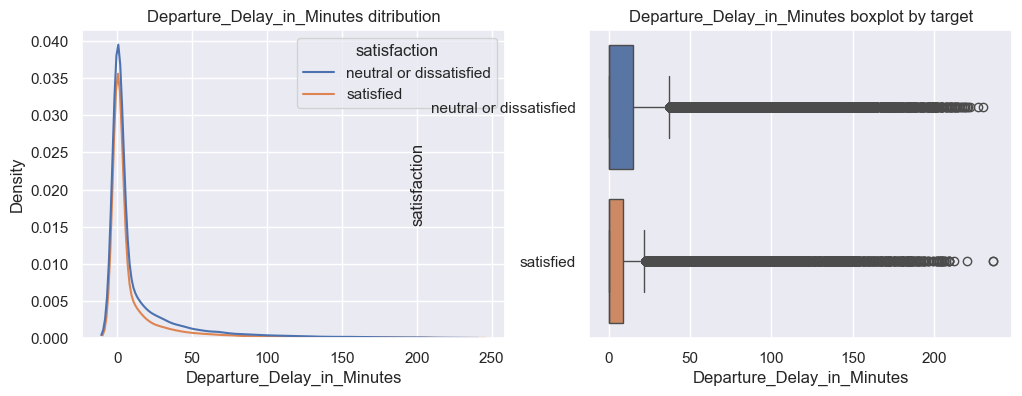

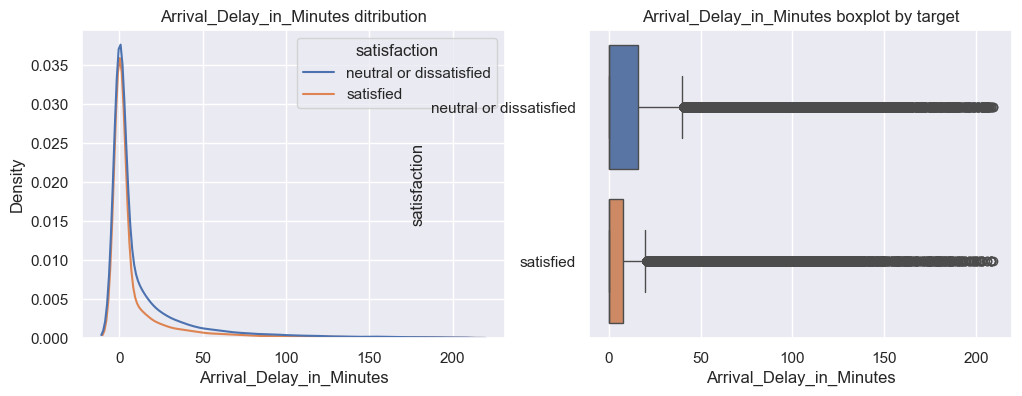

In [850]:
plot_continuous(X_train, y_train, continuous_cols) 

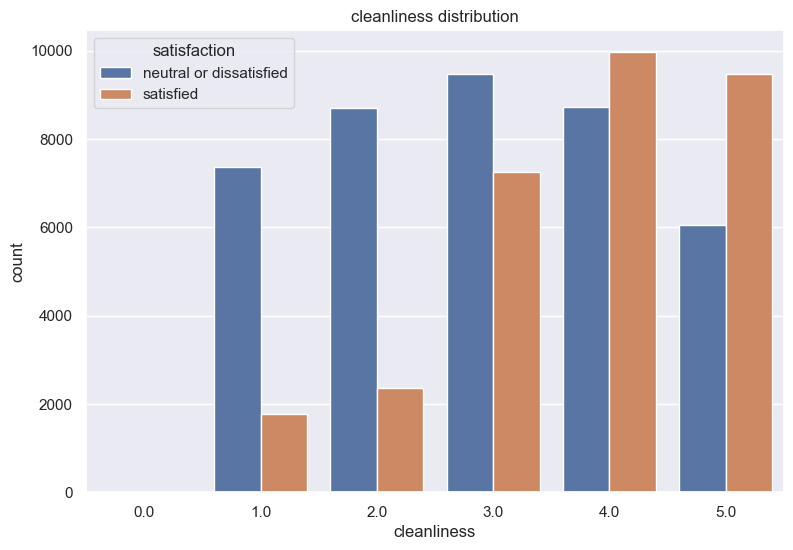

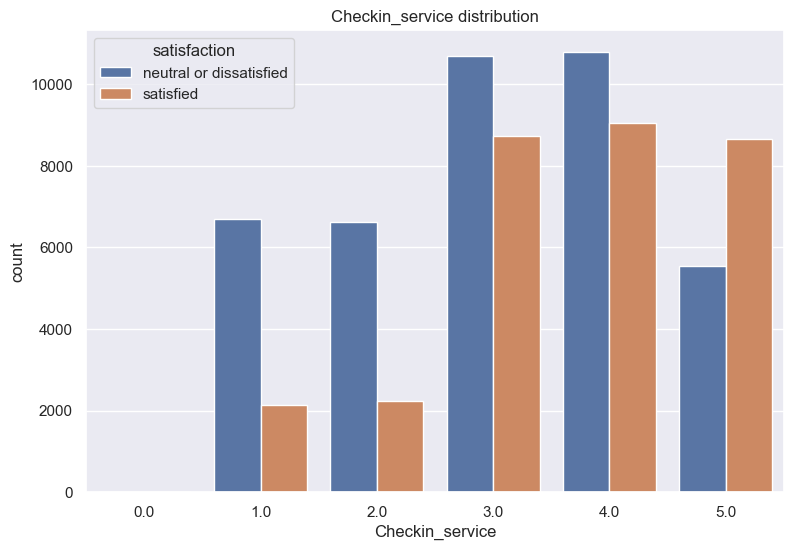

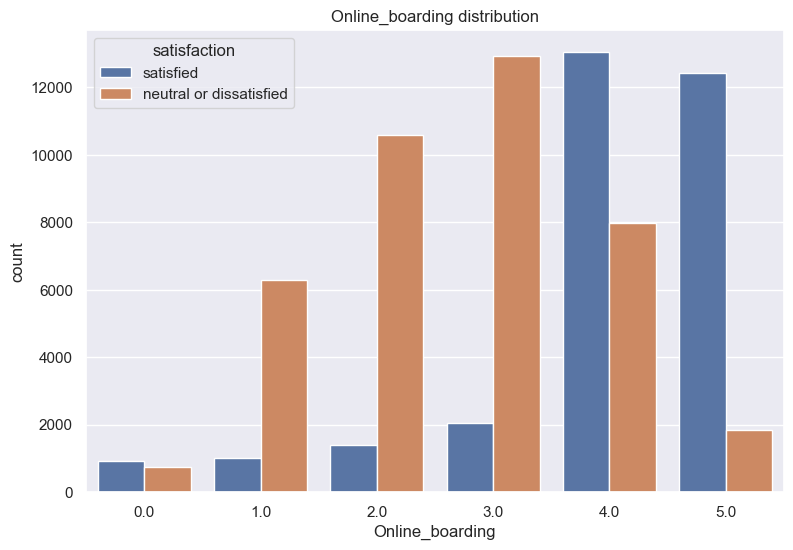

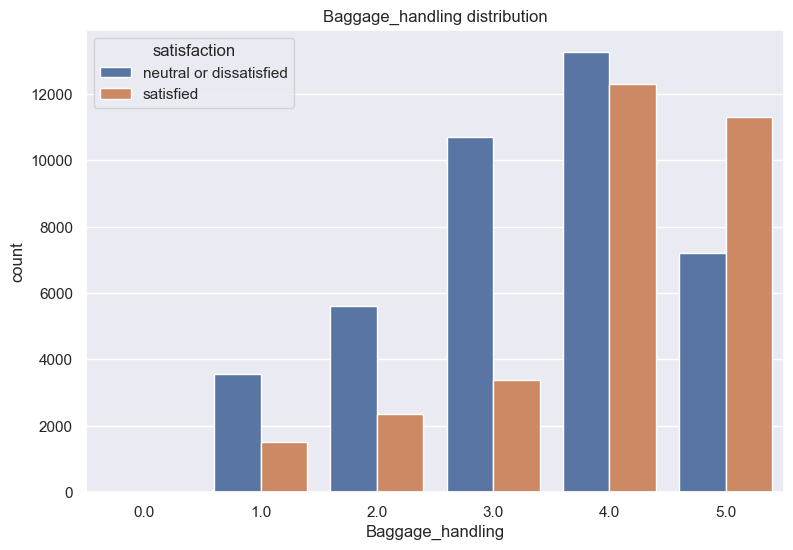

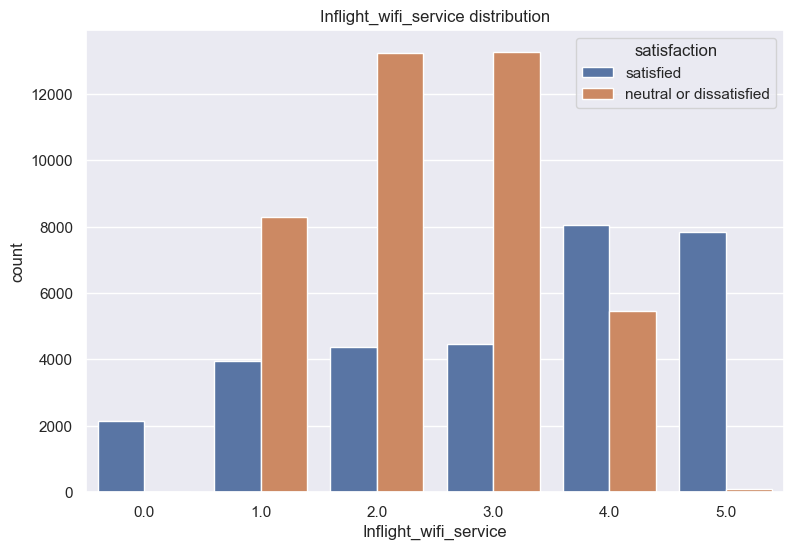

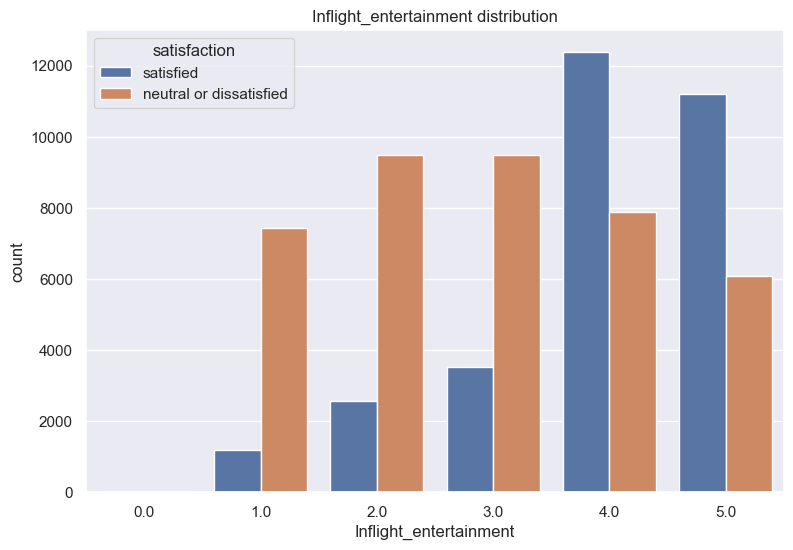

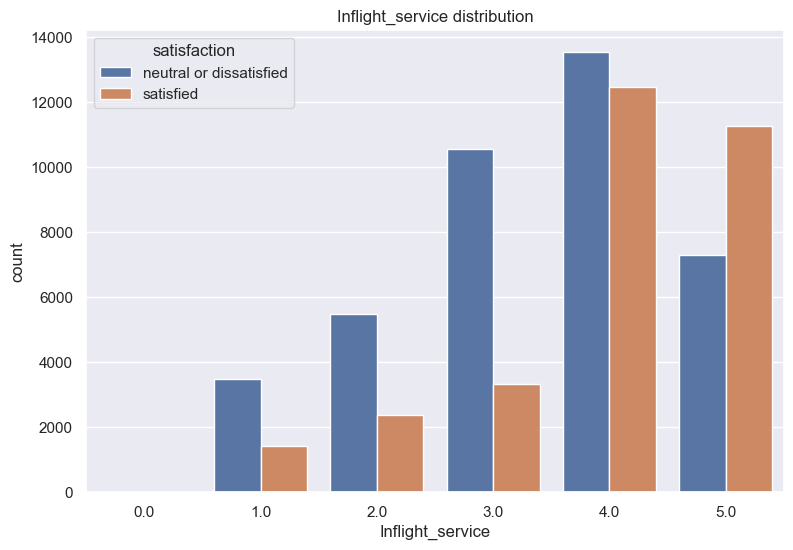

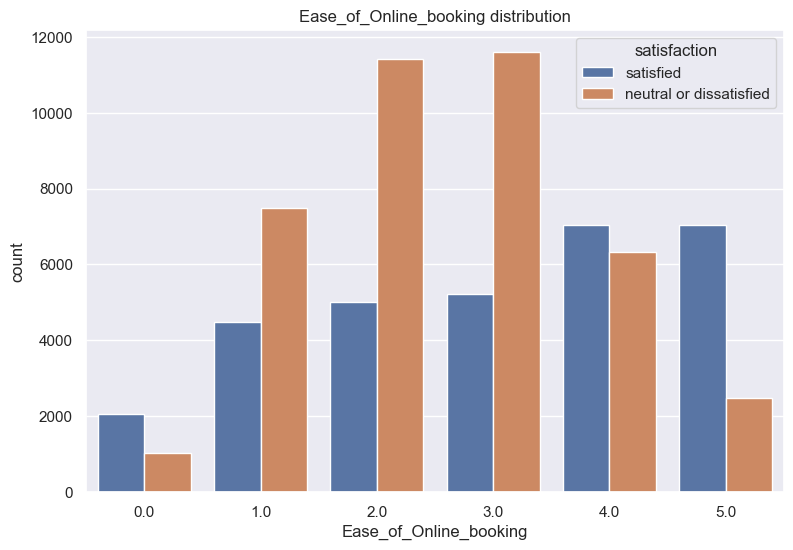

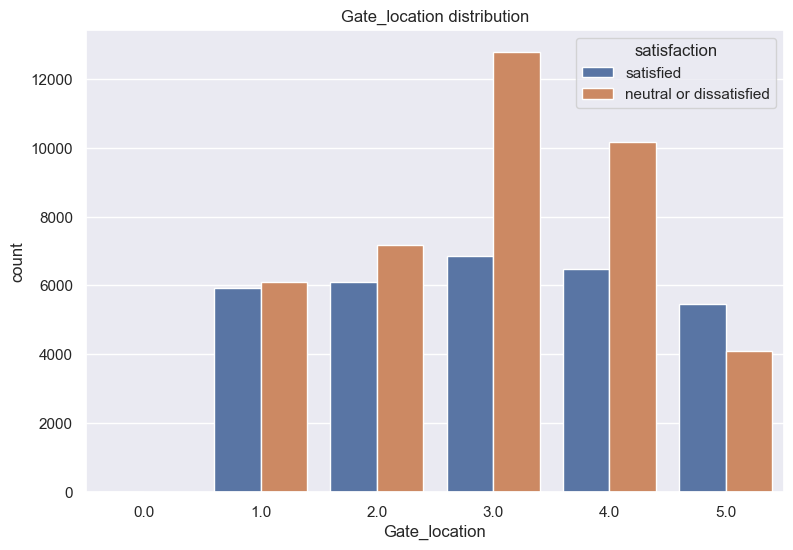

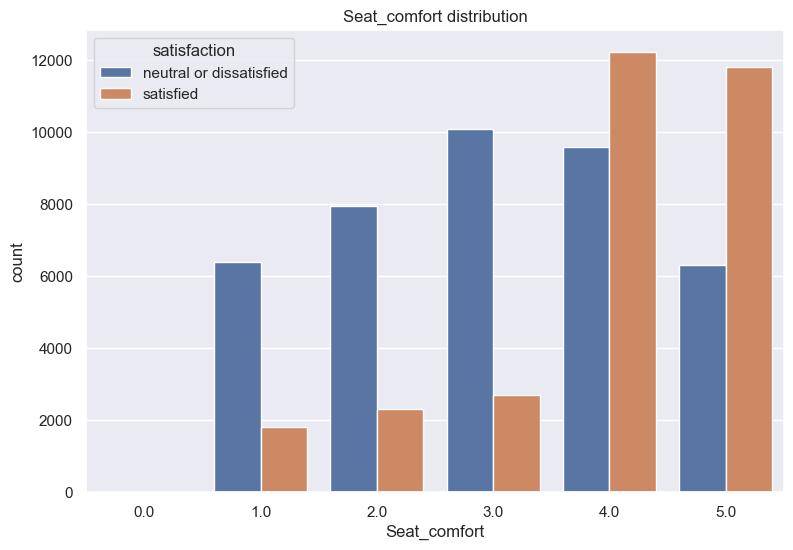

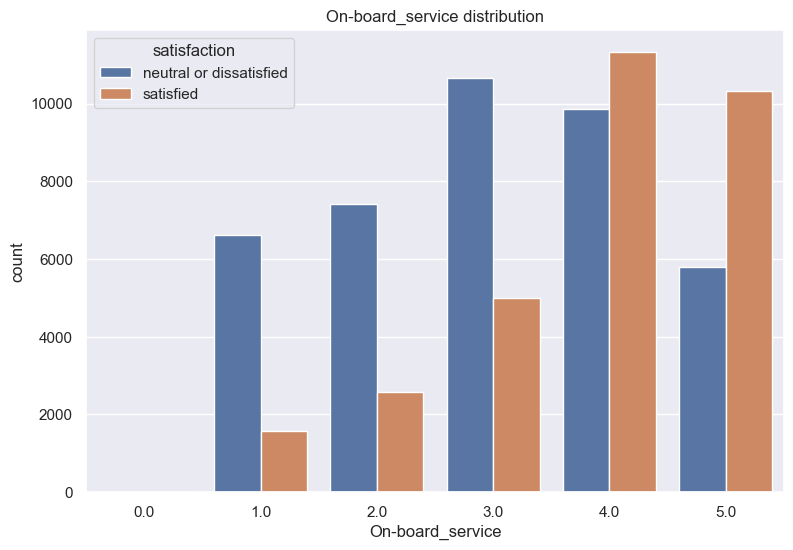

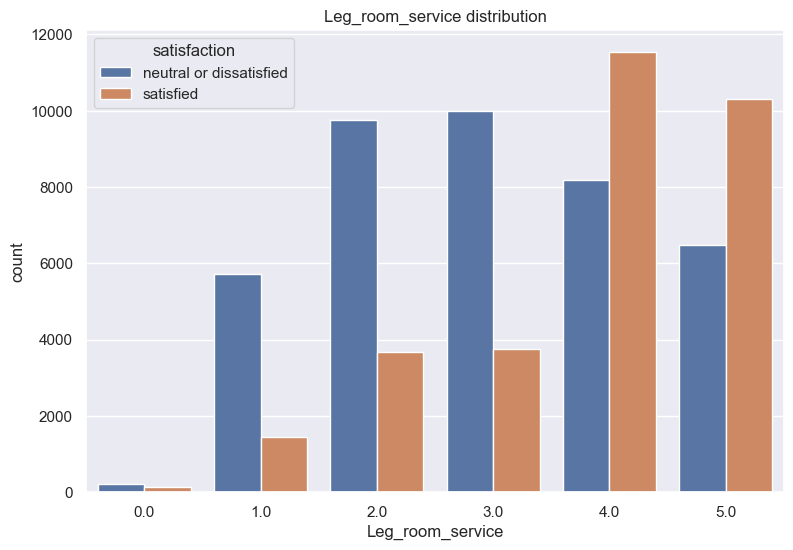

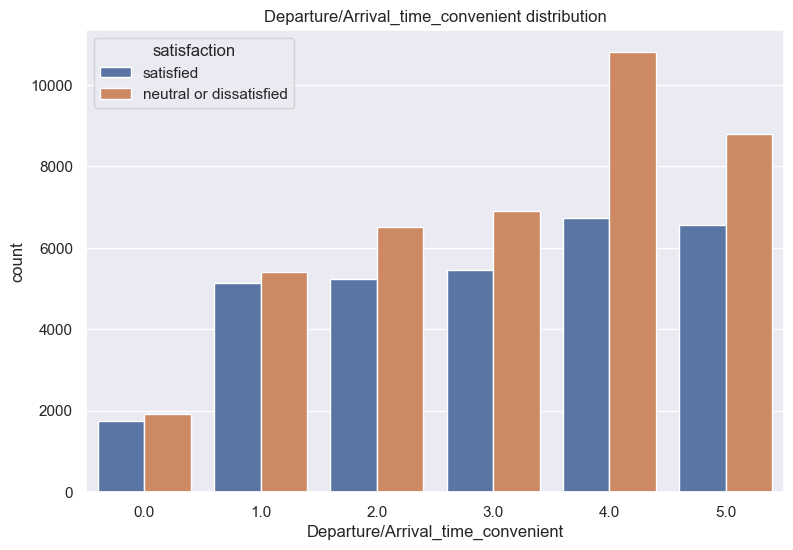

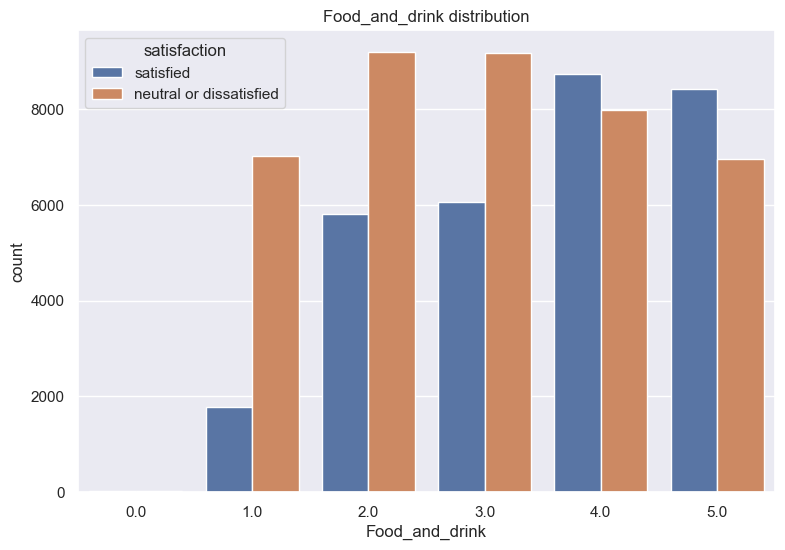

In [851]:
plot_ordinal(X_train, y_train, ordinal_cols)

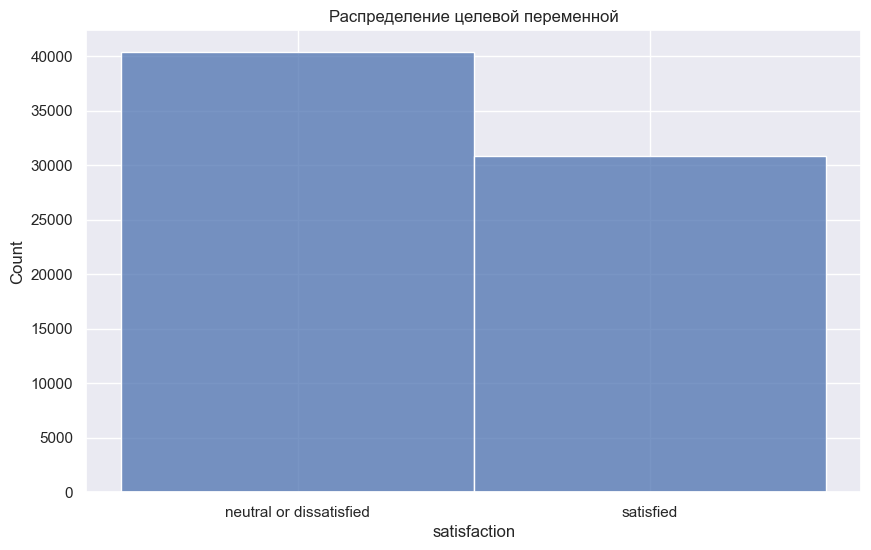

In [852]:
# visualize y_train y_train
sns.histplot(data=y_train)

plt.title('Распределение целевой переменной')
plt.show()

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

___age___

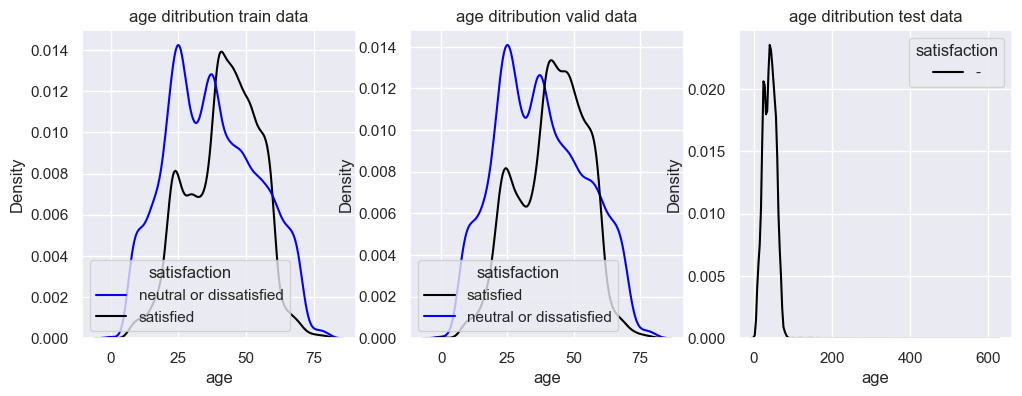

In [853]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))

sns.kdeplot(x=X_train['age'], hue=y_train, ax=ax[0]
            , palette={'neutral or dissatisfied':'blue', 'satisfied':'black'}).set_title(f"age ditribution train data")
sns.kdeplot(x=X_val['age'], hue=y_val, ax=ax[1]
            , palette={'neutral or dissatisfied':'blue', 'satisfied':'black'}).set_title(f"age ditribution valid data")
sns.kdeplot(x=df_test['age'], hue=df_test_y, ax=ax[2], palette={'-':'black'}
           ).set_title(f"age ditribution test data")

plt.show()

___Online_boarding train___

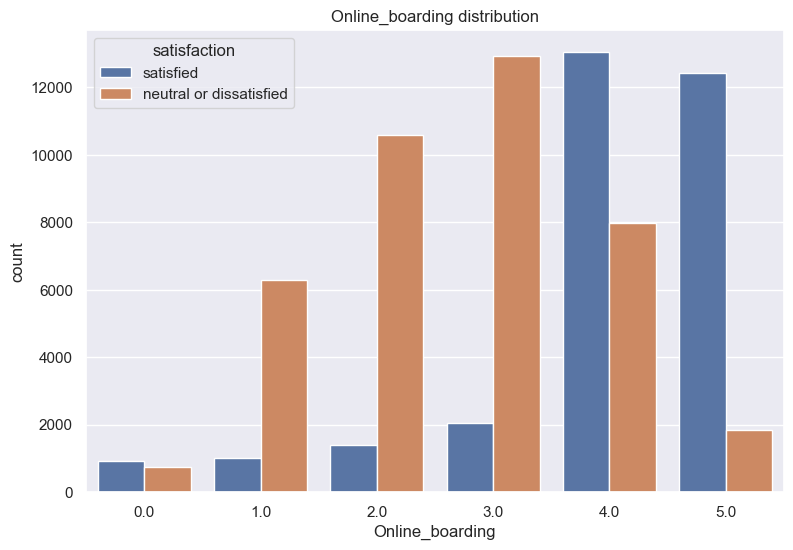

In [854]:
# Online_boarding train
plot_ordinal(X_train, y_train, cols=['Online_boarding'])

___Online_boarding val___

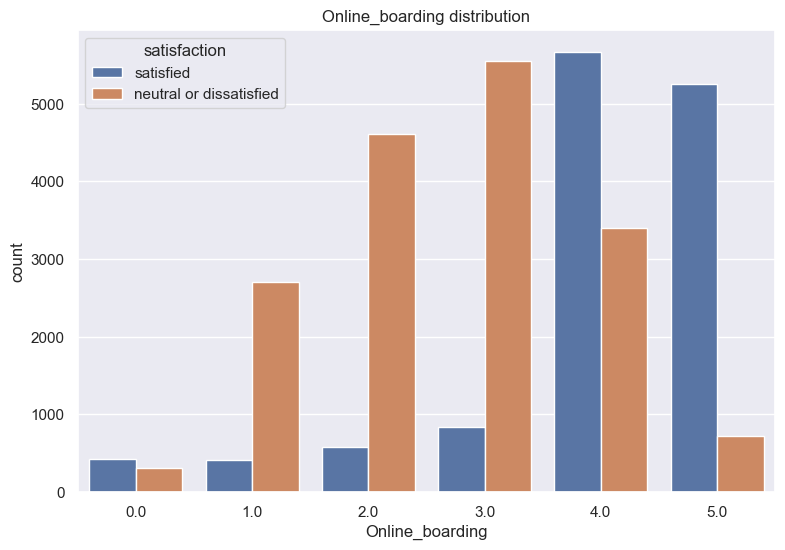

In [855]:
# Online_boarding train
plot_ordinal(X_val, y_val, cols=['Online_boarding'])

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [856]:
# df для дальнейших графиков (пс понимаю, что плодить дф в прод разработки смерти подабно (для пк) но тут забил
X_train_eda = X_train.copy()
X_val_eda = X_val.copy()

In [857]:
#Departure Delay in Minutes, Arrival Delay in Minutes
# Добавим eps что бы не логорифмировать 0
eps = 0.00000000001

max = X_train['Arrival_Delay_in_Minutes'].max()
print(max, ' - max before')

for data in [X_train, X_val, df_test]:
    data['Departure_Delay_in_Minutes'] = np.log(data['Departure_Delay_in_Minutes']+eps)
    data['Arrival_Delay_in_Minutes'] = np.log(data['Arrival_Delay_in_Minutes']+eps)

max = X_train['Arrival_Delay_in_Minutes'].max()
print(max, ' - max after log')

209.0  - max before
5.342334251964859  - max after log


Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

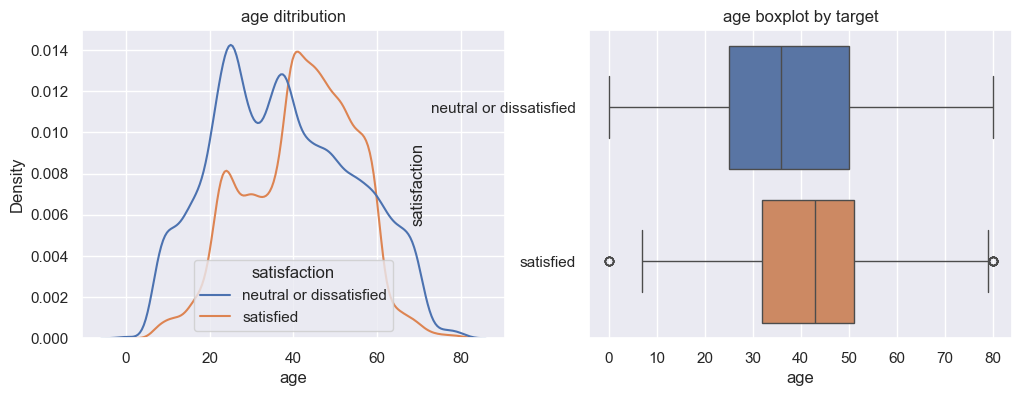

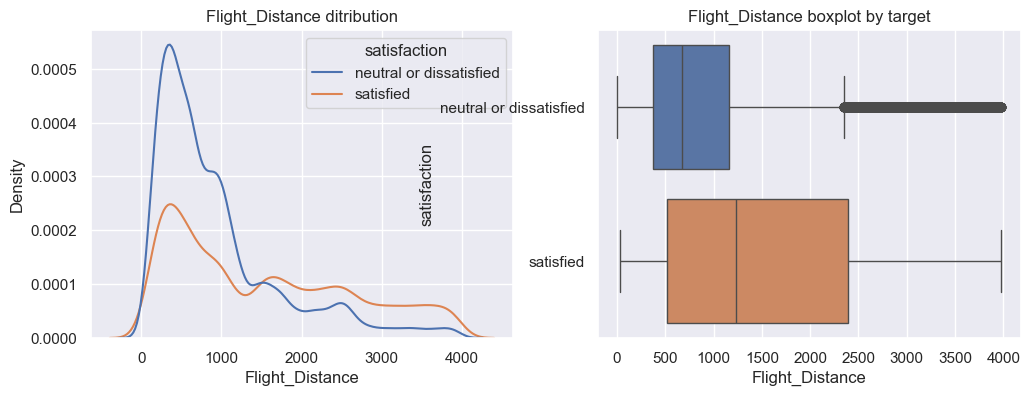

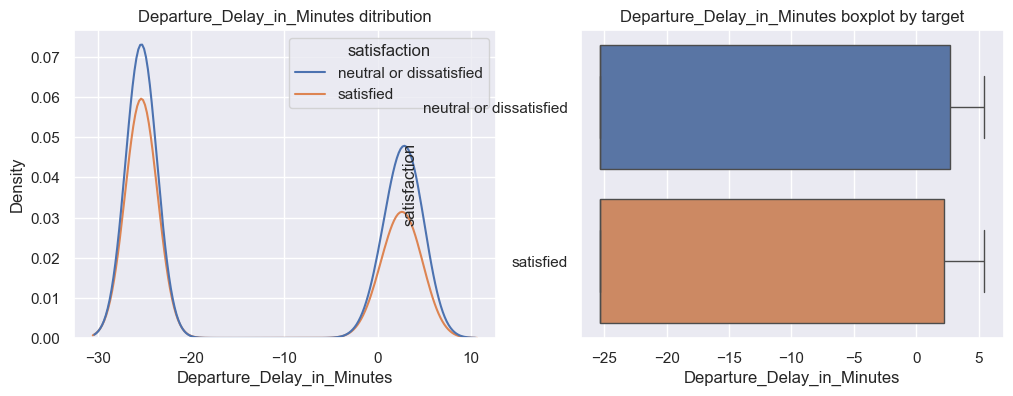

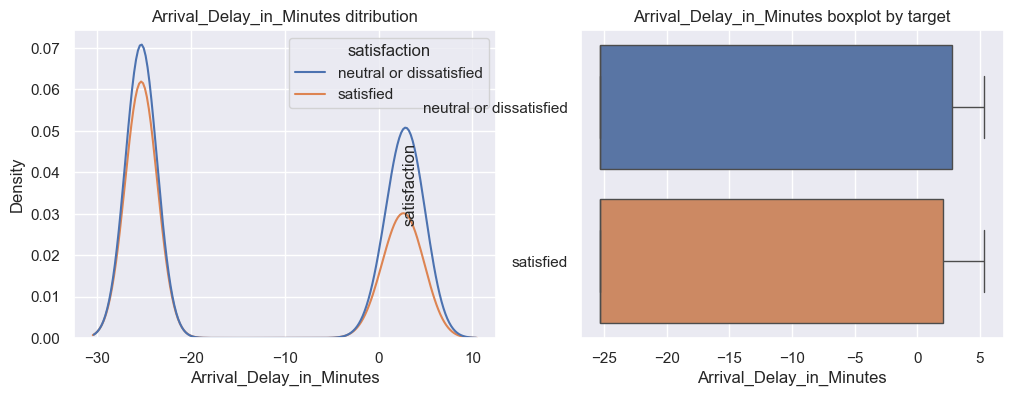

In [858]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [35]:
def target_coder(y: np.array) -> np.array:
    '''Функция преобразует значения таргета satisfied в бинарное распределение
    
    input: 'satisfied' or 'neutral or dissatisfied']
    output: 1 for 'satisfied' and 0 for neutral or dissatisfied
    '''

    # Проверка на допустимые значения
    assert y.nunique() == 2
    for el in y.unique():
        if el not in ['satisfied', 'neutral or dissatisfied']:
            raise not_avaliable_value(f'{el} is not evaliable for thos function')

    # разметка для таргета
    y = y.map({
        'satisfied' : 1,
        'neutral or dissatisfied' : 0
    })

    return y

In [36]:
y_train.head()

id
2031     neutral or dissatisfied
11597                  satisfied
74668    neutral or dissatisfied
31602    neutral or dissatisfied
51518                  satisfied
Name: satisfaction, dtype: object

In [37]:
y_train  = target_coder(y_train)
y_val  = target_coder(y_val)

y_train.head()

id
2031     0
11597    1
74668    0
31602    0
51518    1
Name: satisfaction, dtype: int64

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

In [862]:
df_to_plot = pd.concat([X_train[continuous_cols], y_train], axis=1)
df_to_plot

age  Flight_Distance  Departure_Delay_in_Minutes  \
id                                                          
2031    29.0            785.0                  -25.328436   
11597   45.0           3269.0                  -25.328436   
74668    8.0           1431.0                  -25.328436   
31602   48.0            602.0                  -25.328436   
51518   25.0            651.0                  -25.328436   
...      ...              ...                         ...   
63360   25.0            337.0                  -25.328436   
29678   77.0           1448.0                  -25.328436   
118743  31.0            304.0                    3.044522   
8922    45.0            661.0                  -25.328436   
28513   55.0           1359.0                  -25.328436   

        Arrival_Delay_in_Minutes  satisfaction  
id                                              
2031                  -25.328436             0  
11597                 -25.328436             1  
74668                 -25.328436             0  
31602                 -25.328436             0  
51518                 -25.328436             1  
...                          ...           ...  
63360                 -25.328436             0  
29678                 -25.328436             0  
118743                  2.484907             0  
8922                  -25.328436             1  
28513                 -25.328436             0  

[71175 rows x 5 columns]

In [863]:
# Пропуски
df_to_plot.isna().sum().sum()

0

Попарное распределение континуальных признаков c операции логарифмированния


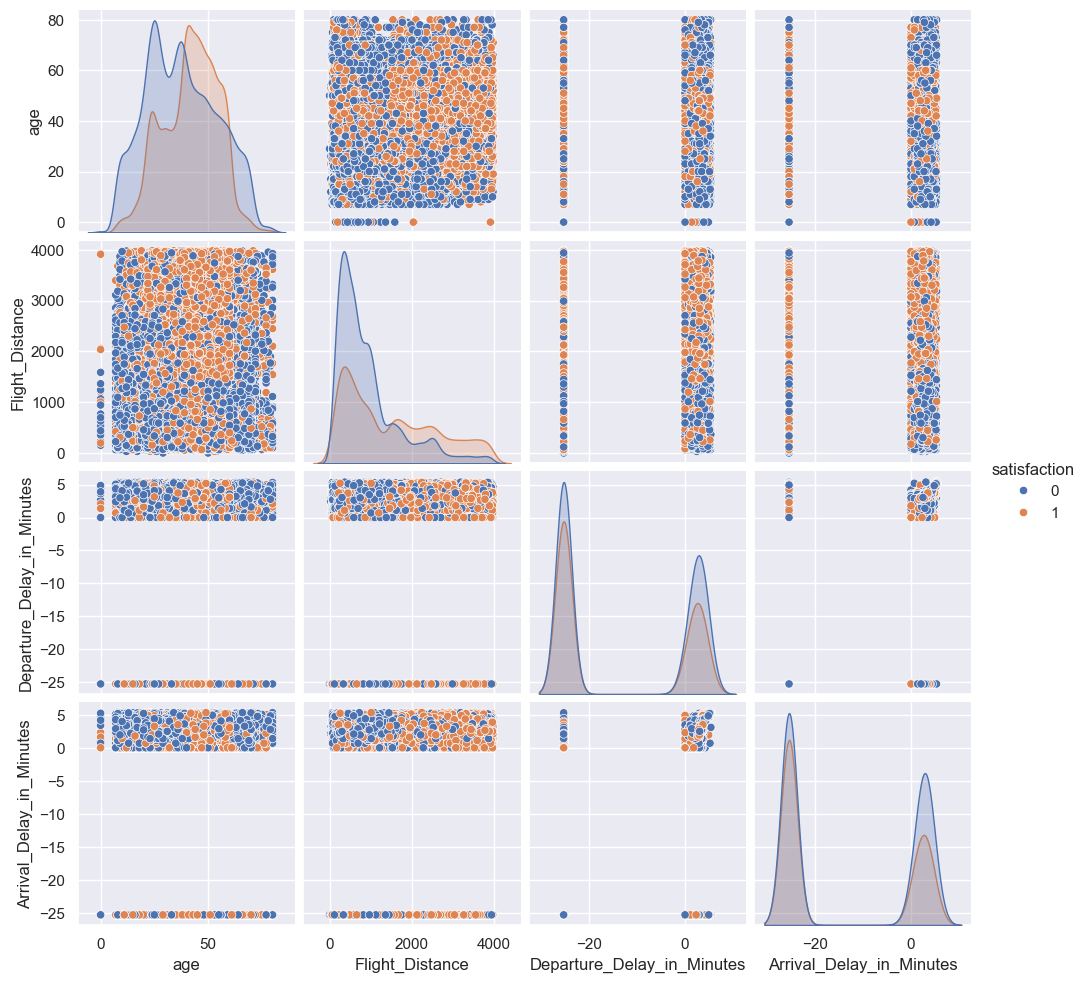

In [864]:
print('Попарное распределение континуальных признаков c операции логарифмированния')
sns.pairplot(
    df_to_plot
    , hue='satisfaction')

plt.show()

Попарное распределение континуальных признаков без операции логарифмированния


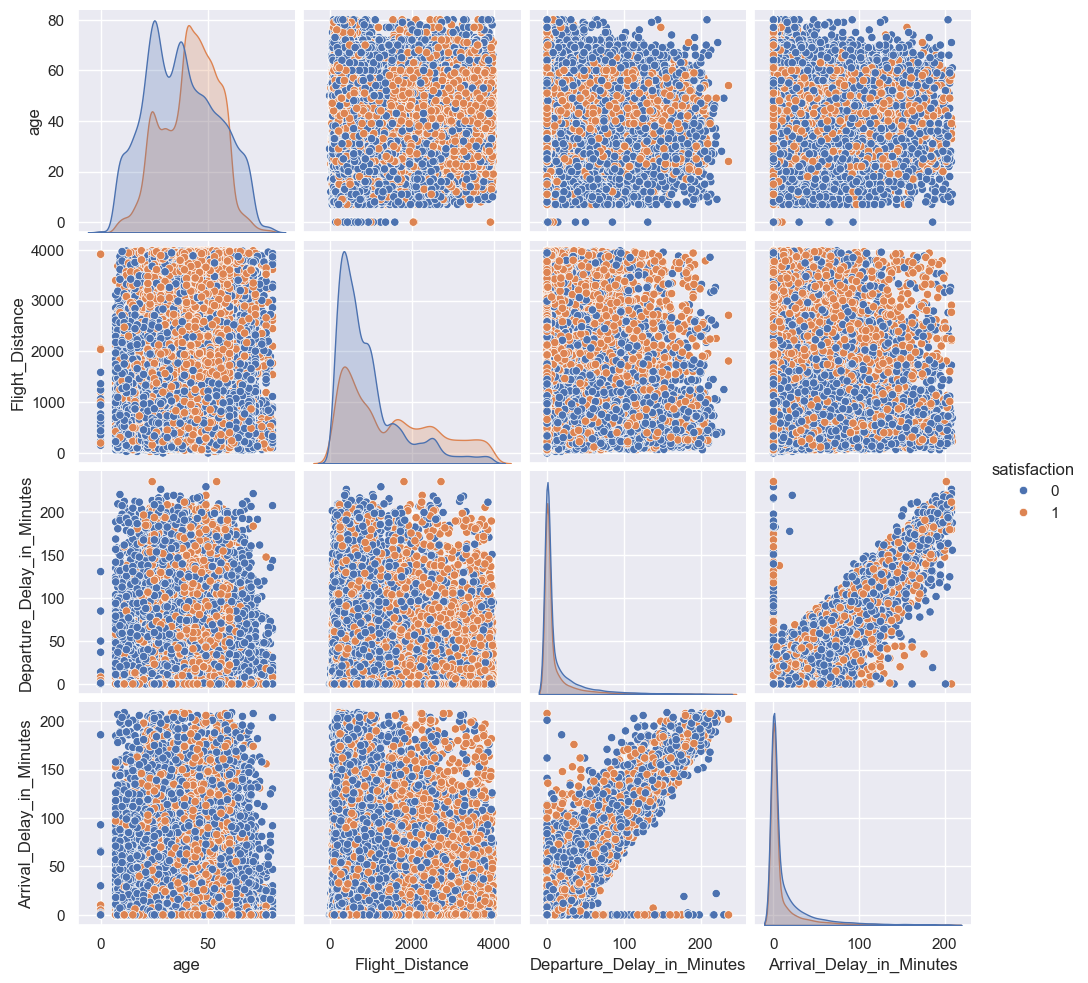

In [865]:
print('Попарное распределение континуальных признаков без операции логарифмированния')

# X_train_eda без логарифмирования признаков
df_to_plot = pd.concat([X_train_eda[continuous_cols], y_train], axis=1) 
# Не должно быть пропусков
assert df_to_plot.isna().sum().sum() == 0

sns.pairplot(
    df_to_plot
    , hue='satisfaction')

plt.show()

In [866]:
del X_train_eda
del X_val_eda

# Decision Tree (3 балла)

(0.5 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [38]:
cat_cols = ['gender', 'Customer_Type', 'Type_of_Travel', 'class']

In [39]:
X_train_copy = X_train.copy()
X_val_copy = X_val.copy()

In [40]:
#X_train = X_train_copy.copy()
#X_val = X_val_copy.copy()

In [41]:
ohe = OneHotEncoder(sparse=False)

# Матрица OHE
X_train_ohe_cat = ohe.fit_transform(X_train[cat_cols])
X_val_ohe_cat = ohe.transform(X_val[cat_cols])

In [42]:
# Добавим название фичей к столбцам
X_train_ohe_cat = pd.DataFrame(X_train_ohe_cat, columns= ohe.get_feature_names_out())
X_val_ohe_cat = pd.DataFrame(X_val_ohe_cat, columns= ohe.get_feature_names_out())

In [43]:
# Соединим исходный df без кат-ых колонок, добавив OHE колонки. Часто будем образаться к этому DF в дальнейшем
X_train = pd.concat(
    [X_train.drop(cat_cols, axis=1).reset_index(drop=True), X_train_ohe_cat.reset_index(drop=True)],
    axis=1
)

X_val = pd.concat(
    [X_val.drop(cat_cols, axis=1).reset_index(drop=True), X_val_ohe_cat.reset_index(drop=True)],
    axis=1
)

In [44]:
# Вернем индексы
X_train.index = X_train_copy.index

X_val.index = X_val_copy.index
X_val.head()

age  Flight_Distance  Departure_Delay_in_Minutes  \
id                                                          
62191   55.0           1065.0                         0.0   
71183   43.0            733.0                         0.0   
128411  23.0            370.0                        52.0   
12840   35.0            489.0                         6.0   
28753   24.0           1024.0                         5.0   

        Arrival_Delay_in_Minutes  Inflight_wifi_service  \
id                                                        
62191                        0.0                    3.0   
71183                        0.0                    5.0   
128411                      47.0                    2.0   
12840                       12.0                    2.0   
28753                        6.0                    4.0   

        Departure/Arrival_time_convenient  Ease_of_Online_booking  \
id                                                                  
62191                                 3.0                     3.0   
71183                                 5.0                     1.0   
128411                                1.0                     2.0   
12840                                 3.0                     2.0   
28753                                 4.0                     4.0   

        Gate_location  Food_and_drink  Online_boarding  Seat_comfort  ...  \
id                                                                    ...   
62191             3.0             1.0              4.0           1.0  ...   
71183             5.0             4.0              4.0           4.0  ...   
128411            3.0             2.0              2.0           2.0  ...   
12840             3.0             5.0              2.0           3.0  ...   
28753             3.0             5.0              4.0           5.0  ...   

        Inflight_service  cleanliness  gender_Female  gender_Male  \
id                                                                  
62191                4.0          3.0            0.0          1.0   
71183                4.0          3.0            0.0          1.0   
128411               3.0          2.0            0.0          1.0   
12840                1.0          5.0            1.0          0.0   
28753                4.0          5.0            0.0          1.0   

        Customer_Type_Loyal Customer  Customer_Type_disloyal Customer  \
id                                                                      
62191                            1.0                              0.0   
71183                            1.0                              0.0   
128411                           0.0                              1.0   
12840                            1.0                              0.0   
28753                            0.0                              1.0   

        Type_of_Travel_Business travel  Type_of_Travel_Personal Travel  \
id                                                                       
62191                              1.0                             0.0   
71183                              1.0                             0.0   
128411                             1.0                             0.0   
12840                              0.0                             1.0   
28753                              1.0                             0.0   

        class_Business  class_Eco  class_Eco Plus  
id                                                 
62191              1.0        0.0             0.0  
71183              1.0        0.0             0.0  
128411             0.0        1.0             0.0  
12840              0.0        1.0             0.0  
28753              0.0        1.0             0.0  

[5 rows x 27 columns]

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для валидационной подвыборки

In [45]:
tree_default = DecisionTreeClassifier()

tree_default.fit(X_train, y_train)

pred = tree_default.predict(X_val)

In [46]:
accuracy_score(y_val, pred)

0.9442221930745016

## Деревья решений. Теоретическая вставка

(0.5 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [881]:
# change *params into what needs to be there by task condition

error_dt, bias_dt, var_dt = bias_variance_decomp(
    tree_default, 
    X_train.values, 
    y_train.values, 
    X_val.values, 
    y_val.values, 
    loss='0-1_loss'
)

error_dt, bias_dt, var_dt

(0.059635362014690455, 0.03931663168940189, 0.04408250262329486)

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

In [47]:
# инициалищируем df для значимости модели
df_base_tree_feature = pd.DataFrame(columns=X_train.columns)
# вставим значимость моделей
df_base_tree_feature.loc[0] = tree_default.feature_importances_

In [48]:
# Транспонируем матрицу, выведем топ полезных признаков
df_base_tree_feature = df_base_tree_feature.T
df_base_tree_feature.columns = ['value']
df_base_tree_feature.sort_values('value', ascending=False).head()

value
Online_boarding                 0.362210
Inflight_wifi_service           0.177373
Type_of_Travel_Business travel  0.147195
Inflight_entertainment          0.047176
Customer_Type_Loyal Customer    0.029944

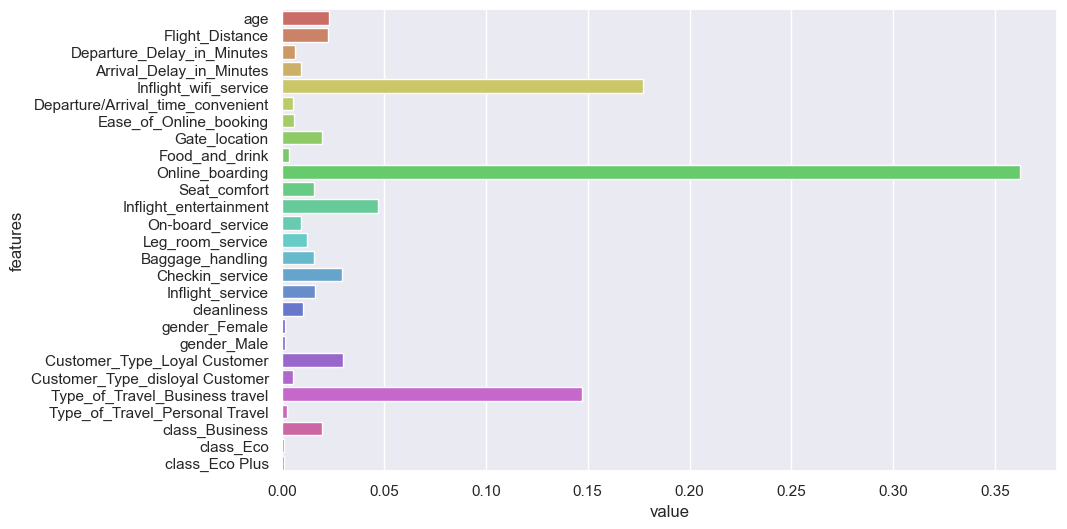

In [49]:
sns.set(rc={'figure.figsize':(10,6)}) 

sns.barplot(x=df_base_tree_feature['value'], y=df_base_tree_feature.index, palette='hls')

plt.ylabel('features')

plt.show()

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [887]:
depth = tree_default.tree_.max_depth
n_leavs = tree_default.tree_.node_count

print(f'Глубина дерева {depth}, кол-во листьев {n_leavs}')

Глубина дерева 35, кол-во листьев 4055


<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [888]:
tree_penek = DecisionTreeClassifier(max_depth=5)

tree_penek.fit(X_train[['Online_boarding','Inflight_wifi_service']], y_train)

pred_penek = tree_penek.predict(X_val[['Online_boarding','Inflight_wifi_service']])

In [889]:
print(f'base model score - {accuracy_score(y_val, pred)}, скор высокого пенька с глубиной=5 {accuracy_score(y_val, pred_penek)}')

base model score - 0.9445828961175237, скор высокого пенька с глубиной=5 0.8250918153200419


(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

In [50]:
from sklearn import tree

In [891]:
str_feature_names = [str(x) for x in tree_penek.classes_]

graphiz_data = tree.export_graphviz(
    tree_penek,
    feature_names=tree_penek.feature_names_in_,
    class_names=str_feature_names
)

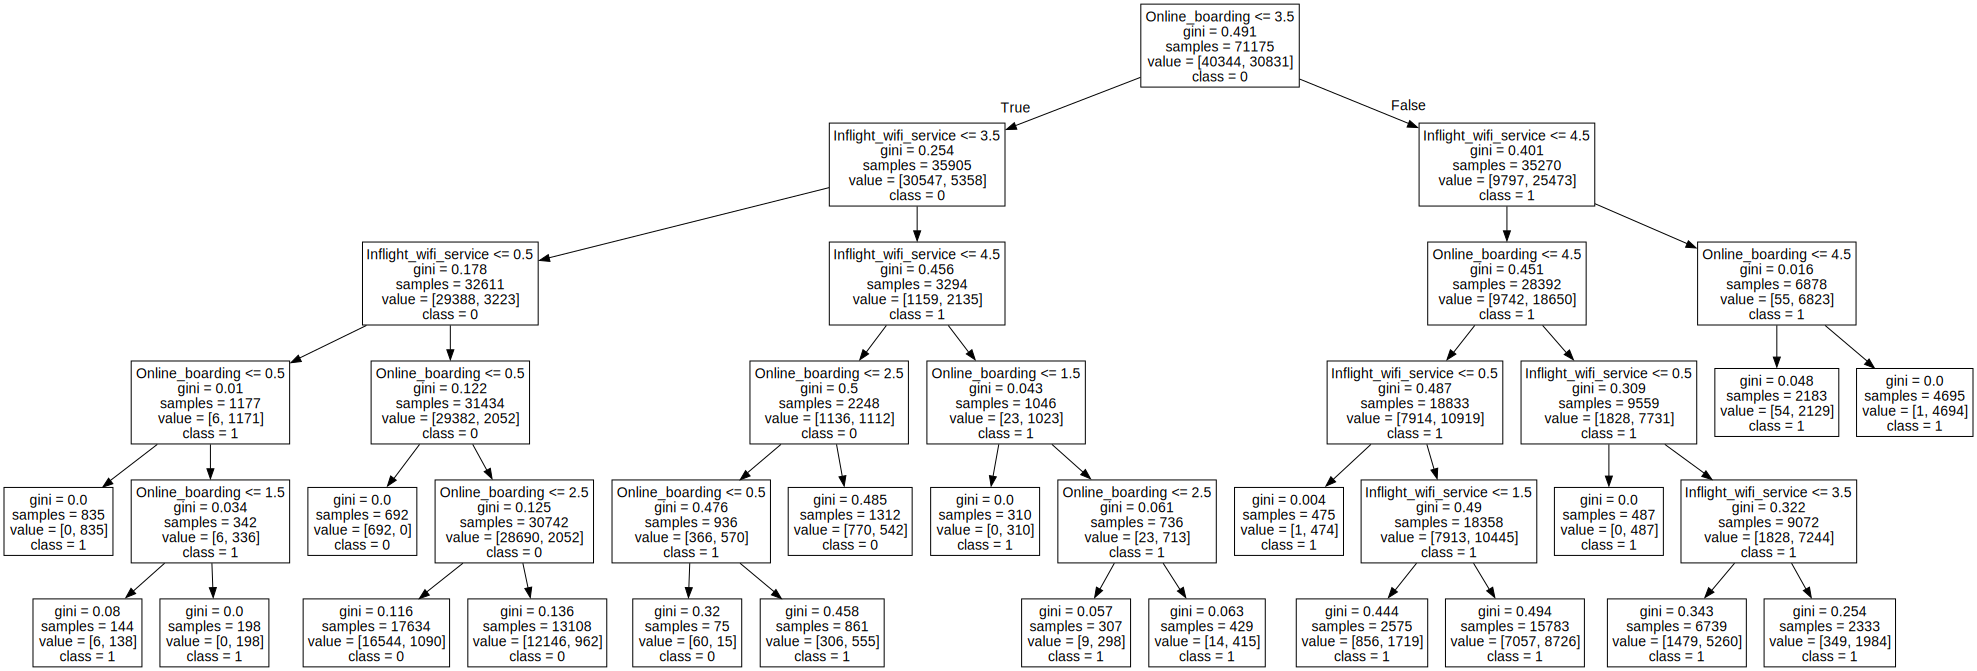

In [892]:
# Рисуем дерево
graph = Source(graphiz_data, format="png") 
graph

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договорённости) признаков</font>

In [893]:
feature_values = df_base_tree_feature.sort_values('value', ascending=False).reset_index()

In [894]:
feature_values[feature_values['index'].isin(continuous_cols)]

index     value
5              Flight_Distance  0.026983
6                          age  0.023768
16  Departure_Delay_in_Minutes  0.007711
17    Arrival_Delay_in_Minutes  0.007704

In [895]:
tree_penek_cont_cols = DecisionTreeClassifier(max_depth=5)

tree_penek_cont_cols.fit(X_train[['Flight_Distance','age']], y_train)

pred_penek_cont_cols = tree_penek_cont_cols.predict(X_val[['Flight_Distance','age']])

accuracy_score(y_val, pred_penek_cont_cols)

0.6834994753410283

(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

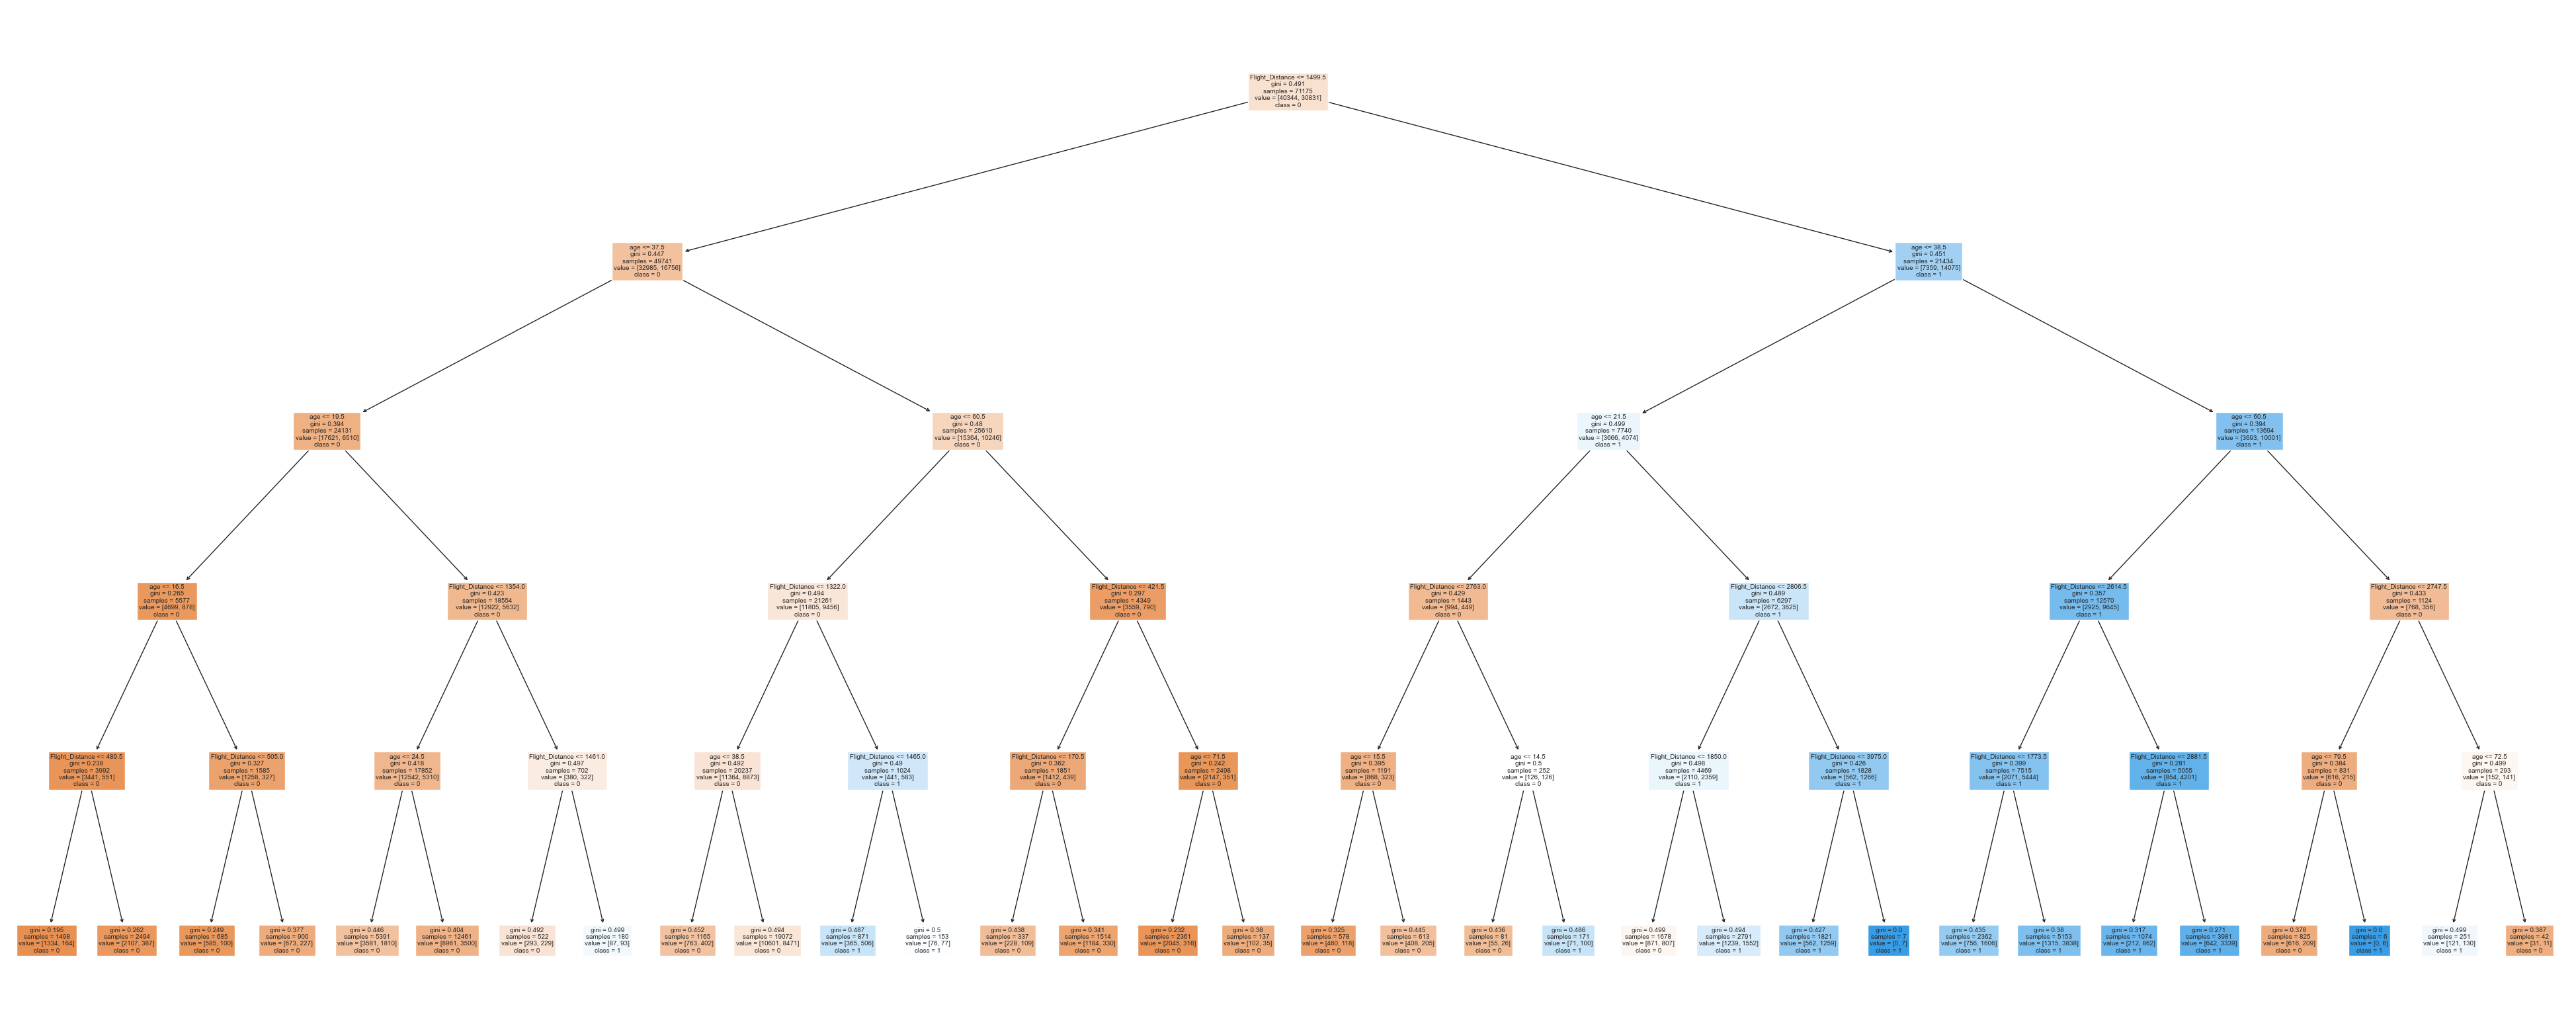

In [896]:
str_feature_names = [str(x) for x in tree_penek_cont_cols.classes_]

# Рисуем дерево
plt.figure(figsize=(50,20))
#tree.plot_tree(tree_penek_cont_cols)
tree.plot_tree(tree_penek_cont_cols,
             feature_names=tree_penek_cont_cols.feature_names_in_,
             class_names=str_feature_names,
             filled=True)

plt.show()

Да, дерево получилось симметричным. Я считаю, что не важно симметричное ли дерево решений или ассеметричное - разве что второе сложнее интерпретировать. Куда более важнее способность дерева разбивать классы в вершинах и, например, если будет такая ситуация (ниже) - почему бы нам не разбить жадным образом, а не пытаться строить симмитречиное дерево в угоду красоте:

[1000, 2000] (вершина) ->
  
-> [500, 0] (левая ветка) 

-> [500, 2000] (правая ветка)

Тут у нас получилось симметричное дерево, так как мы огриничили его глубину на раннем этапе, когда модель не смогла выделить лист, который содержит один вид класса и продолжнала его разбивать до глебины=5 - поэтому дерево получилось симметричным

(0.5 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

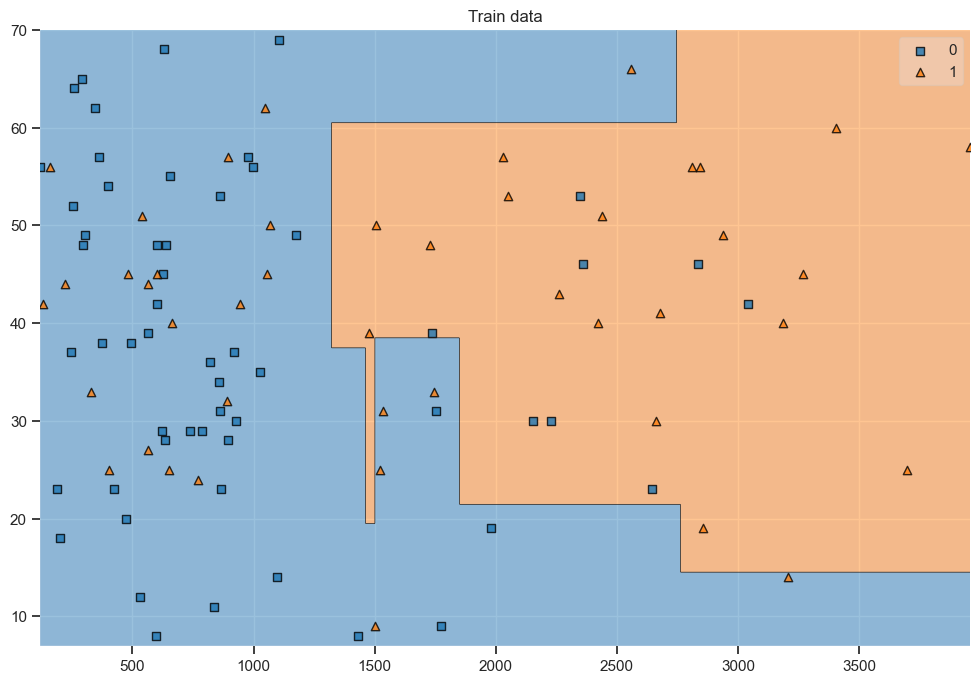

In [897]:
plt.figure(figsize=(12,8))

# строим границы решений
plot_decision_regions(
    	X=X_train[['Flight_Distance','age']][:100].values,
    	y=y_train[:100].values,
    	clf=tree_penek_cont_cols,
        feature_index=[0, 1] # Указываем два признака для построения графика
)

plt.title('Train data')

plt.show()

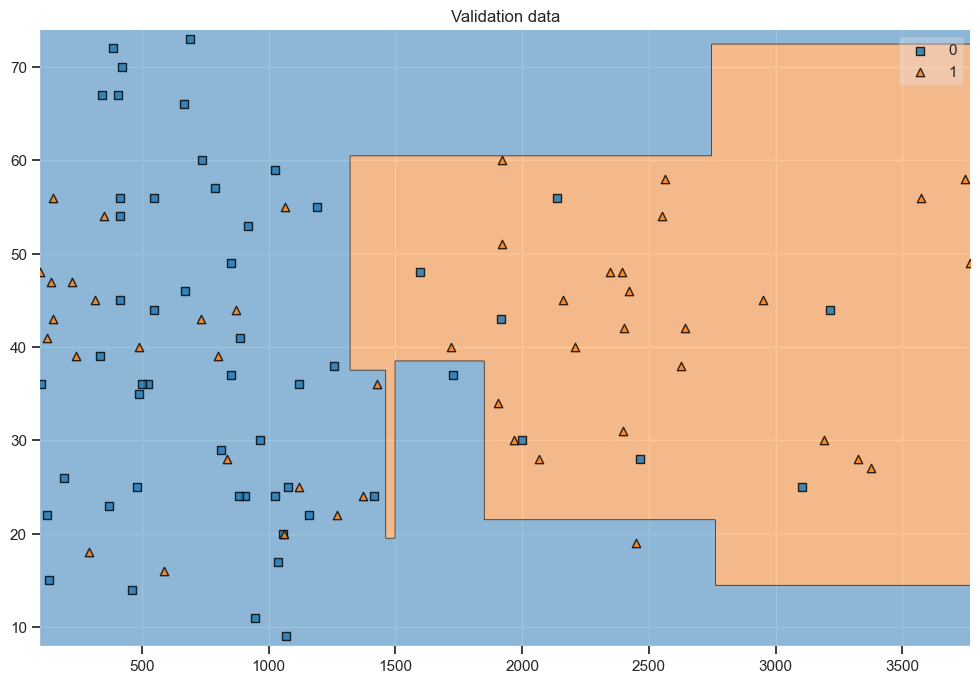

In [898]:
# Валидационная выборка (интересно)

plt.figure(figsize=(12,8))

# строим границы решений
plot_decision_regions(
    	X=X_val[['Flight_Distance','age']][:100].values,
    	y=y_val[:100].values,
    	clf=tree_penek_cont_cols,
        feature_index=[0, 1] # Указываем два признака для построения графика
)

plt.title('Validation data')

plt.show()

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

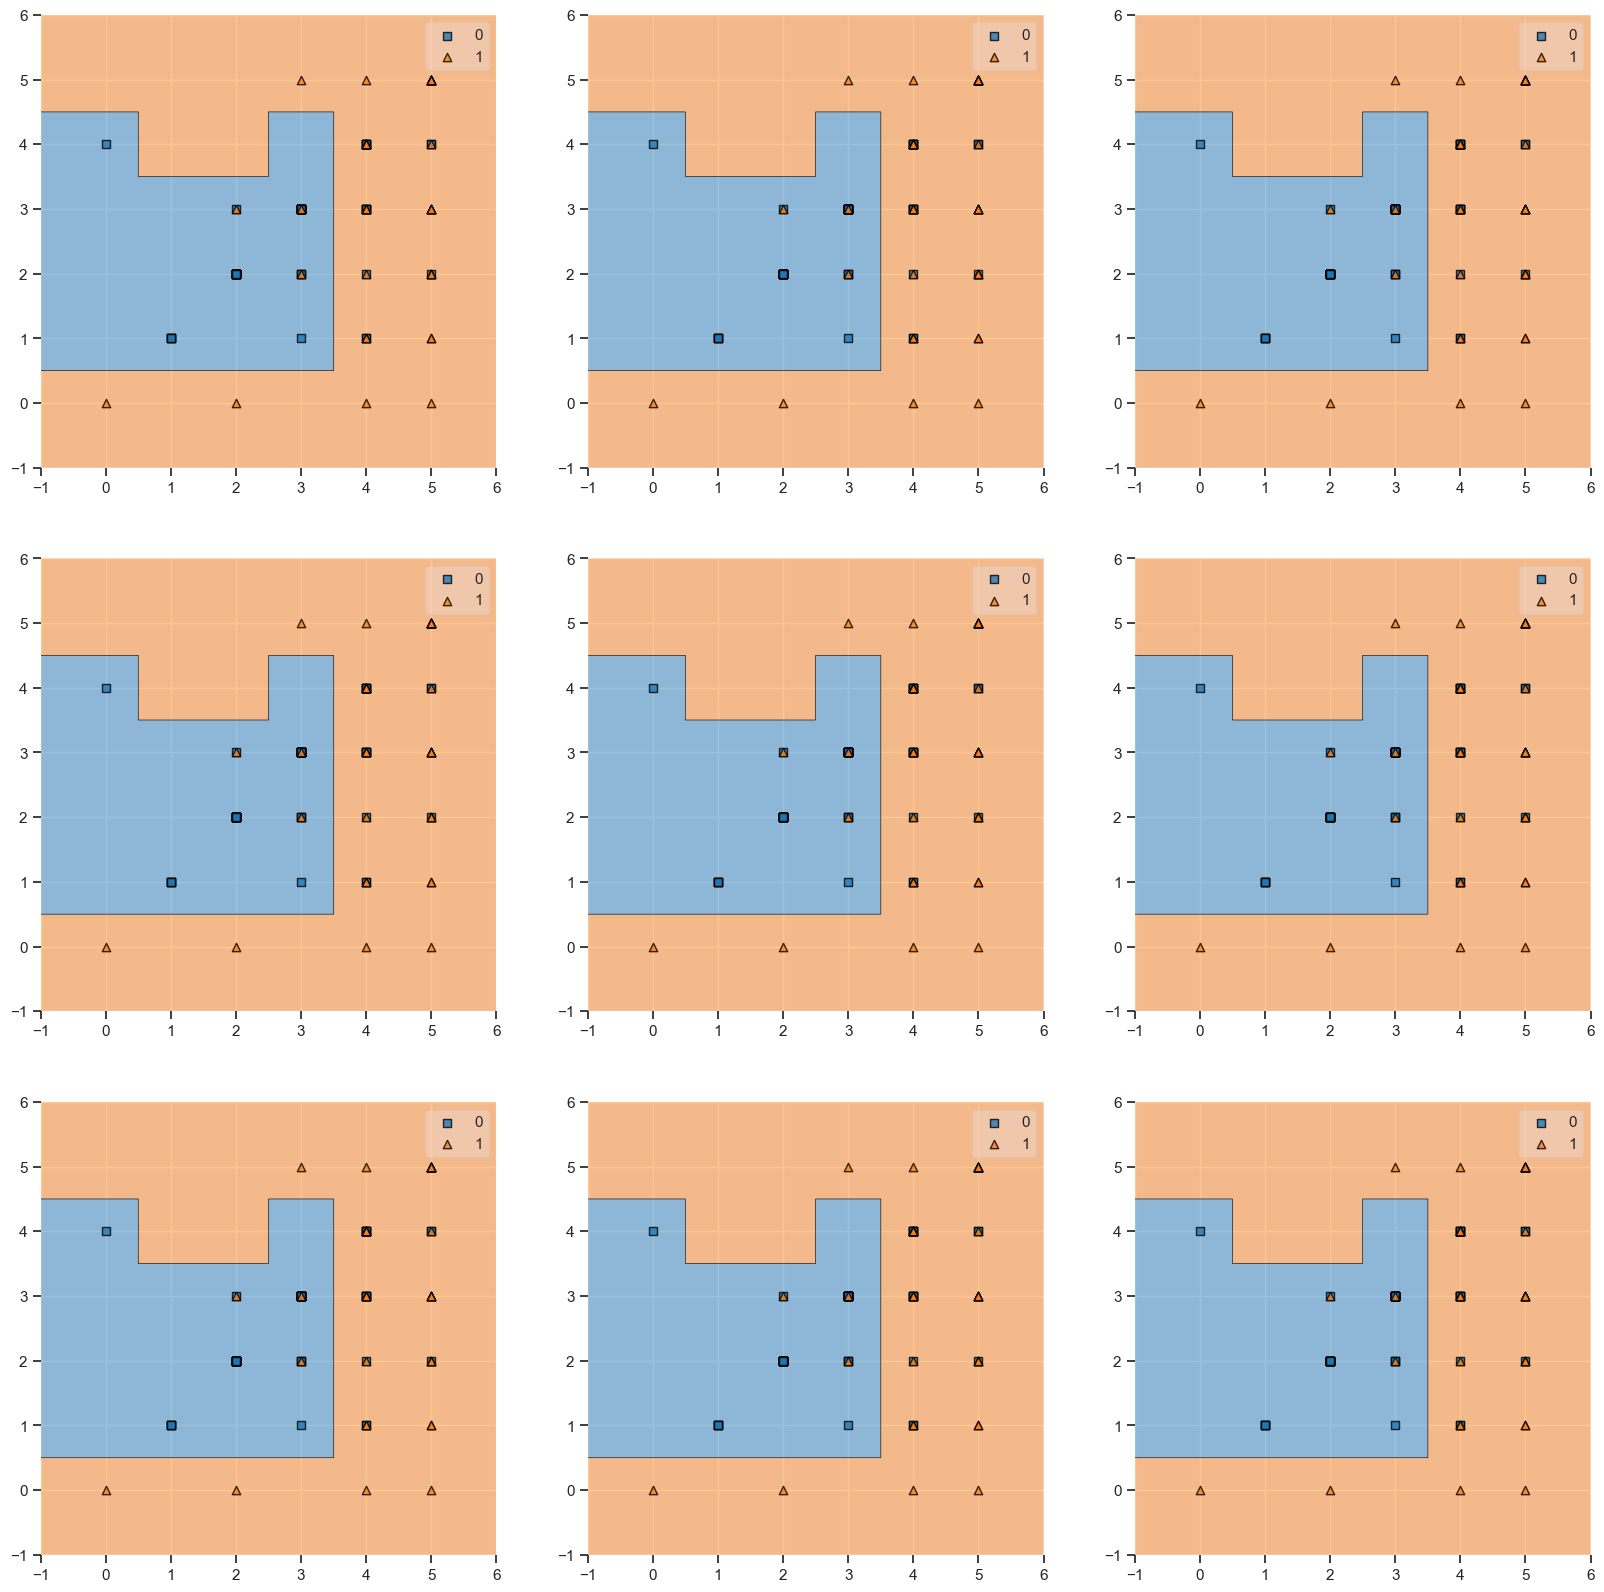

In [908]:
# change X_train_example to your equivalent

# plot_decision_regions ругался, что он может работатьтолько с 2 признаками

X_train_teory = X_train[['Online_boarding','Inflight_wifi_service']]

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_teory.index, size=X_train_teory.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_teory.loc[inds, :], y_train[inds])

        plot_decision_regions(
            clf=tree_exp, 
            X=np.array(X_train_teory.iloc[:100, :]), 
            y=np.array(y_train[:100]), 
            ax=ax[row][col],
            feature_index=[0, 1]
        )
        


Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [910]:
%%time 
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train, y_train)
    y_predicted_train = DT.predict(X_train)
    y_predicted_val = DT.predict(X_val)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 3.26 s, sys: 72.5 ms, total: 3.34 s
Wall time: 3.34 s


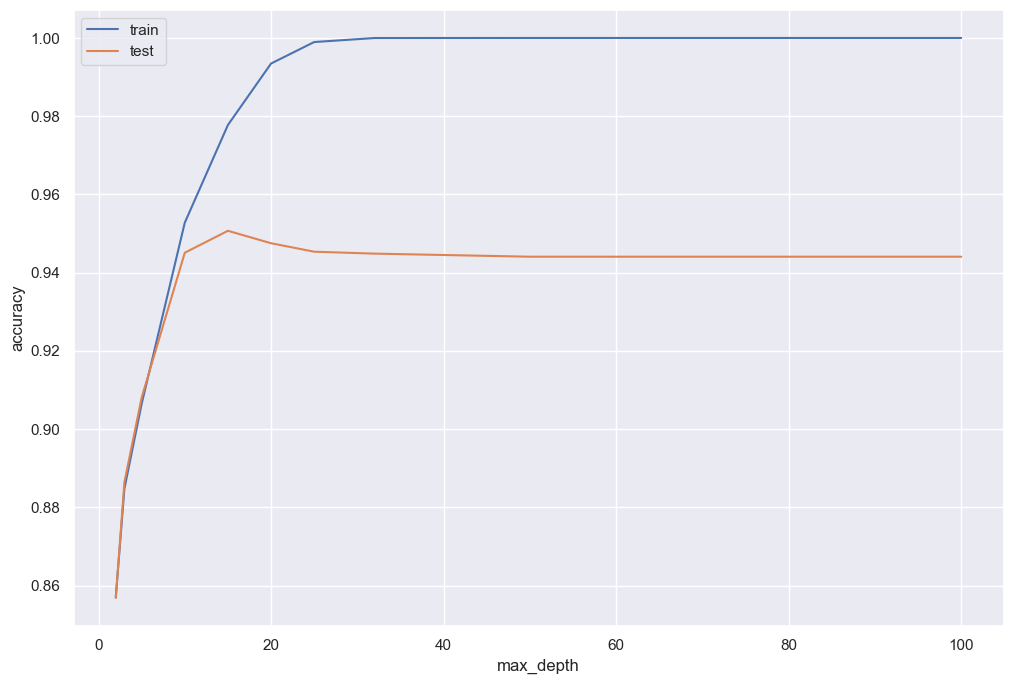

In [911]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font> *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [914]:
param_grid = {
   'criterion': ['gini', 'entropy'],
   'max_depth': [None, 5,10,15,20,25,35,50,75],
   'min_samples_split': [2, 5, 10, 20],
   'min_samples_leaf': [1,2,5,10,20],
   'max_features': [None, 'auto', 'sqrt', 'log2']
}

dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(dtree, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20, 25, 35, 50, 75],
                         'max_features': [None, 'auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='accuracy')

In [918]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 20}

In [919]:
grid_search.best_score_

0.9492799438004917

In [916]:
best_tree = grid_search.best_estimator_
best_tree

DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=20)

In [920]:
pred_best_tree = best_tree.predict(X_val)

accuracy_score(y_val, pred_best_tree)

0.9537644281217209

Значение на валдиации дерева без параметров - 0.9445828961175237, получается мы улучшили скор почти на 0.01 благодаря подбору гиперпараметров. Интересно заметить, что на тесте скор ниже, чем на валидации

<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [923]:
with open('best_tree_hw3.pkl', 'wb') as f:
    pickle.dump(pred_best_tree, f)

# Random Forest (4 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [51]:
# Fit RF
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

# Predict & score
pred_rf = rf.predict(X_val)

accuracy_score(y_val, pred_rf)

0.9621917628541448

(0.75 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

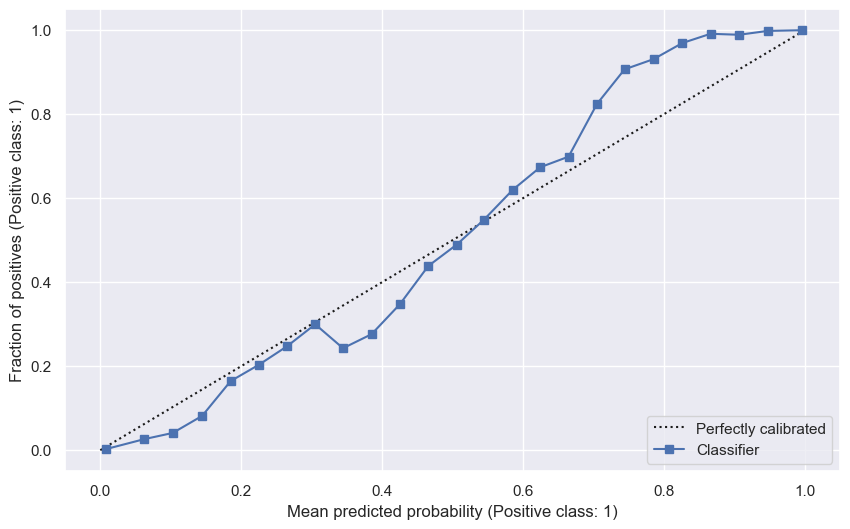

In [963]:
probs_rf = rf.predict_proba(X_val)[:,1]
disp = CalibrationDisplay.from_predictions(y_val, probs_rf, n_bins=25)

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

UPD: не с параметрами по умолчанию, а так, чтоб сошлась

In [969]:
# Определите параметры для поиска
param_grid = {
    'fit_intercept': [True, False],
    'C': np.linspace(0,1, 15),
    'penalty' : ['l1', 'l2', 'elasticnet', None]
}

# Создайте модель
model = LogisticRegression()

# Создайте GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучите модель
grid_search.fit(X_train, y_train)

# Выведите лучшие параметры
print("Best parameters: ", grid_search.best_params_)

/Users/dan/miniconda3/envs/mlops_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/dan/miniconda3/envs/mlops_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/dan/miniconda3/envs/mlops_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/dan/miniconda3/envs/mlops_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/dan/miniconda3/envs/mlops_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/User

Best parameters:  {'C': 0.9285714285714285, 'fit_intercept': True, 'penalty': 'l2'}


In [ ]:
# Best parameters:  {'C': 0.9285714285714285, 'fit_intercept': True, 'penalty': 'l2'}

accuracy_score 0.9616015215110179


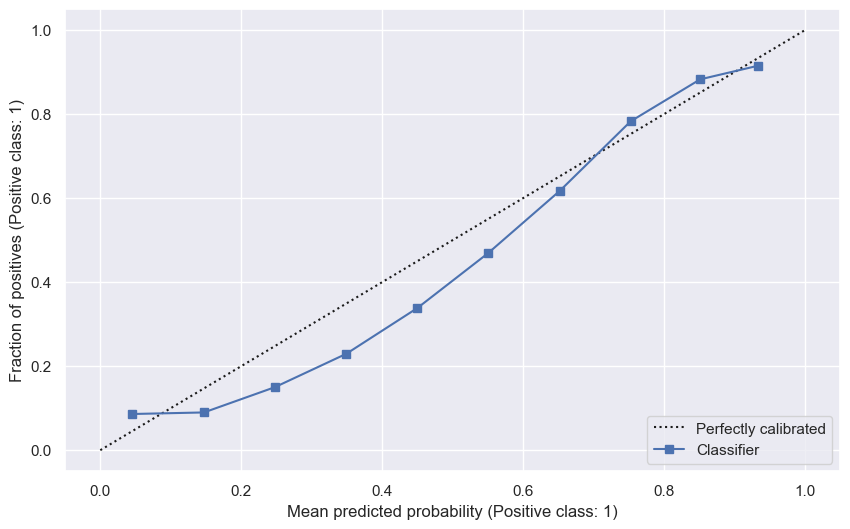

In [979]:
lr = LogisticRegression(C = 0.9285714285714285, fit_intercept = True, penalty = 'l2')

lr.fit(X_train, y_train)
pred - lr.predict(X_val)

print('accuracy_score', accuracy_score(y_val, pred_rf))

probs_lr = lr.predict_proba(X_val)[:,1]
disp = CalibrationDisplay.from_predictions(y_val, probs_lr, n_bins=10)   

Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

(0.75 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

In [974]:
# create X_test, y_test
X_train_calib, X_test_calib, y_train_calib, y_test_calib = train_test_split(
    X_train
    , y_train
    , test_size=0.3
    , random_state=42
)

In [976]:
# Fit RF
rf = RandomForestClassifier()

rf.fit(X_train_calib, y_train_calib)

# Predict & score
pred_rf = rf.predict(X_val)
pred_score_rf = rf.predict_proba(X_val)


accuracy_score(y_val, pred_rf)

0.9616015215110179

___Logreg calib___

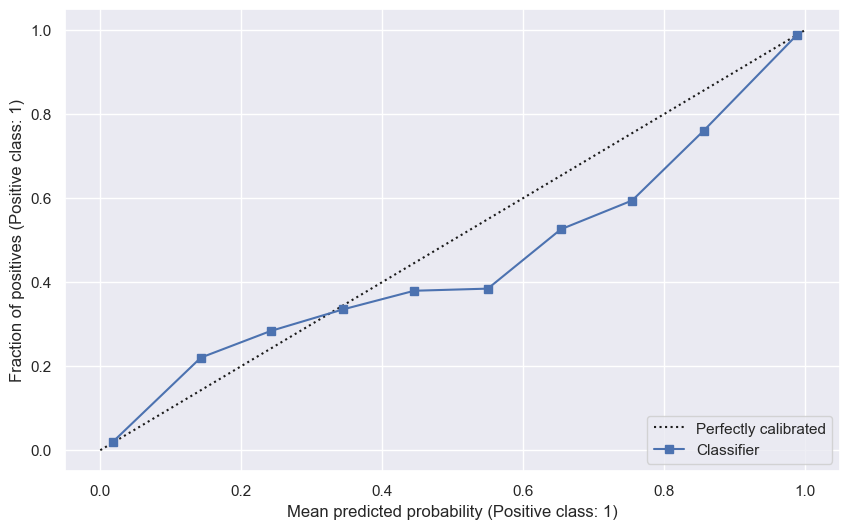

In [998]:
# Fit logreg
lr_calib = LogisticRegression()
lr_calib.fit(pred_score_rf[:,1].reshape(-1, 1), y_val) # обучим на скорах с валидации Лог регрессию

# predict_proba Random Forest на тесте
pred_proba_rf_test = rf.predict_proba(X_test_calib)[:,1].reshape(-1, 1)

# predict_proba Логистической регрессии на скорах Random Forest на тесте
calib_score_logreg_test = lr_calib.predict_proba(pred_proba_rf_test)

disp = CalibrationDisplay.from_predictions(y_test_calib, calib_score_logreg_test[:,1], n_bins=10)   

___Isotonic calib___

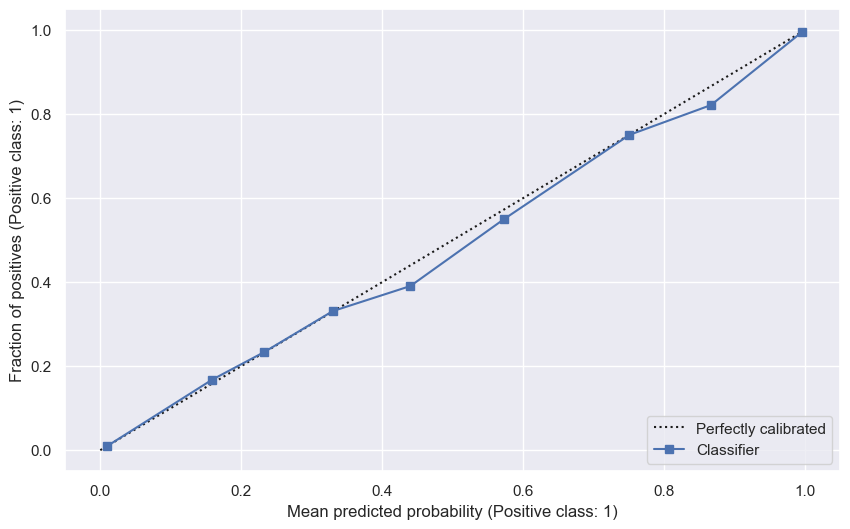

In [1005]:
# Обучим изотоническую регрессию для калибровки 

ir = IsotonicRegression(y_min=0, y_max=1)
ir.fit(pred_score_rf[:, 1], y_val) # обучим на скорах с валидации изотоническую регрессию

# predict_proba изотонической регрессии на скорах Random Forest на тесте
calib_score_ir_test = ir.predict(pred_proba_rf_test)

disp = CalibrationDisplay.from_predictions(y_test_calib, calib_score_ir_test, n_bins=10)

Изотоническая регрессия отработала набного лучше логистической с целью калибровки

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

(1 балл) <font color='#9933CC'>Посчитайте разброс и смещение полученного случайного леса (до калибровки).</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [1007]:
print(f'Base tree: error_dt: {error_dt}, bias_dt {bias_dt}, var_dt {var_dt}')

Base tree: error_dt: 0.059635362014690455, bias_dt 0.03931663168940189, var_dt 0.04408250262329486


In [1009]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
    rf, 
    X_train.values, 
    y_train.values, 
    X_val.values, 
    y_val.values, 
    loss='0-1_loss'
)

print(f'Random forest: error_dt: {error_dt}, bias_dt {bias_dt}, var_dt {var_dt}')

Random forest: error_dt: 0.03920432187827912, bias_dt 0.03731636935991606, var_dt 0.008664578961175236


<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии (ванильной, не той, что использовали для калибровки).</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [1010]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
    lr, 
    X_train.values, 
    y_train.values, 
    X_val.values, 
    y_val.values, 
    loss='0-1_loss'
)

error_dt, bias_dt, var_dt
print(f'Logistic regressor (cv params): error_dt: {error_dt}, bias_dt {bias_dt}, var_dt {var_dt}')

Logistic regressor (cv params): error_dt: 0.17887936122770198, bias_dt 0.17867917103882477, var_dt 0.04582879721930745


(1 балл) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [1017]:
from scipy.stats import randint

In [1021]:
# по меньше параметров

rv_n_estimators = randint(low=200, high=2000)
rv_max_depth = randint(low=10, high=300)

param_grid = {
  'n_estimators': rv_n_estimators.rvs(size=2),  #[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
  'max_depth': rv_max_depth.rvs(size=2), #[int(x) for x in np.linspace(10, 110, num = 11)] + [None],
  'min_samples_leaf': [1, 10]
}


# GridSearchCV
model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# fit
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)

best_rf = grid_search.best_estimator_

Best parameters:  {'max_depth': 24, 'min_samples_leaf': 1, 'n_estimators': 1722}


In [1022]:
# Predict & score
pred_rf = best_rf.predict(X_val)
#pred_score_rf = best_rf.predict_proba(X_val)

accuracy_score(y_val, pred_rf)

0.9625852570828961

## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight_Distance', 'Online_boarding', 'Inflight_wifi_service']
X_train_RF = X_train[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


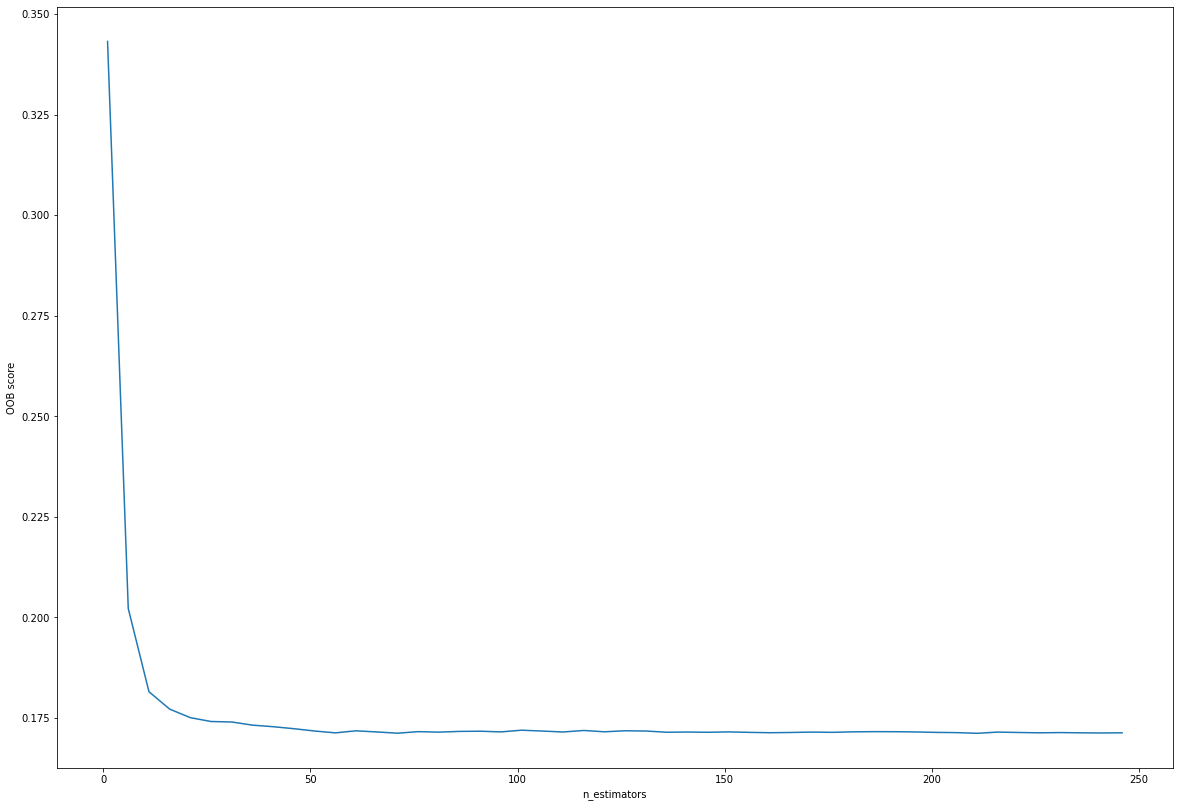

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной 

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

In [54]:
# инициалищируем df для значимости модели
df_rf_feature = pd.DataFrame(columns=X_train.columns)
# вставим значимость моделей
df_rf_feature.loc[0] = best_rf.feature_importances_

In [55]:
# Транспонируем матрицу, выведем топ полезных признаков
df_rf_feature = df_rf_feature.T
df_rf_feature.columns = ['value']
df_rf_feature.sort_values('value', ascending=False).head(10)

value
Online_boarding                 0.167340
Inflight_wifi_service           0.137428
class_Business                  0.068429
Type_of_Travel_Personal Travel  0.064398
Type_of_Travel_Business travel  0.058793
Inflight_entertainment          0.052747
Seat_comfort                    0.046742
Ease_of_Online_booking          0.036474
class_Eco                       0.034824
Leg_room_service                0.032274

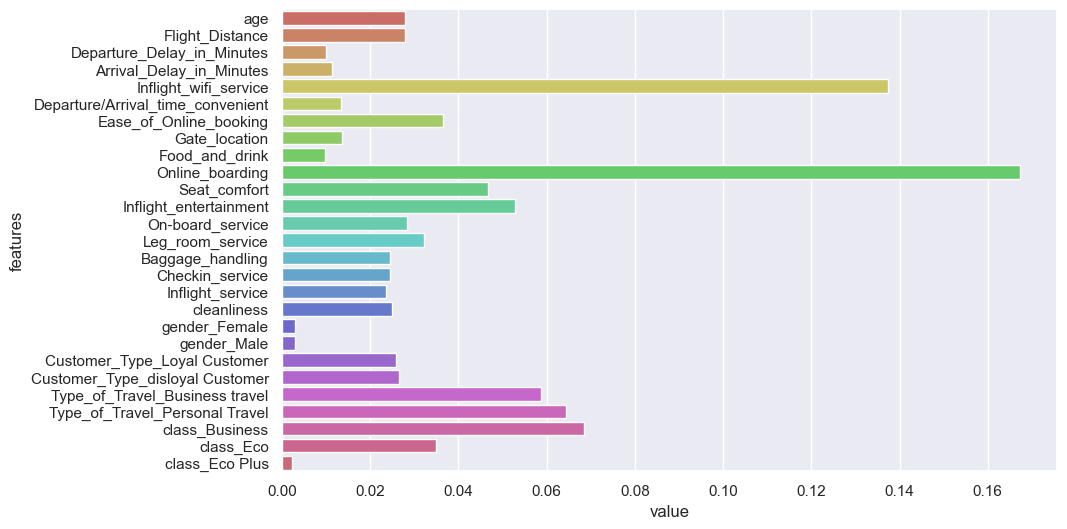

In [56]:
sns.set(rc={'figure.figsize':(10,6)}) 

sns.barplot(x=df_rf_feature['value'], y=df_rf_feature.index, palette='hls')

plt.ylabel('features')

plt.show()

(0.5 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

In [57]:
# Тут признаки дерева, которые выводил ранее
df_base_tree_feature.sort_values('value', ascending=False).head(10)

value
Online_boarding                 0.362210
Inflight_wifi_service           0.177373
Type_of_Travel_Business travel  0.147195
Inflight_entertainment          0.047176
Customer_Type_Loyal Customer    0.029944
Checkin_service                 0.029295
age                             0.022835
Flight_Distance                 0.022738
class_Business                  0.019827
Gate_location                   0.019580

///Тут у меня умер процессор на рассчете shap (перезапусти)///

In [60]:
# Соберем df: feature_name, weight дерева, weight леса
df_base_tree_feature = df_base_tree_feature.reset_index()
df_base_tree_feature.columns = ['feature', 'weight_tree']

df_rf_feature = df_rf_feature.reset_index()
df_rf_feature.columns = ['feature', 'weight_rf']

total_df_features = df_base_tree_feature.merge(df_rf_feature, how='left', on='feature')

In [62]:
# Преобразуем df для построения гарфика
long_df = total_df_features.melt(id_vars='feature', var_name='model_name', value_name='weight_score')

In [65]:
long_df.head()

feature   model_name  weight_score
0                         age  weight_tree      0.022835
1             Flight_Distance  weight_tree      0.022738
2  Departure_Delay_in_Minutes  weight_tree      0.006222
3    Arrival_Delay_in_Minutes  weight_tree      0.009299
4       Inflight_wifi_service  weight_tree      0.177373

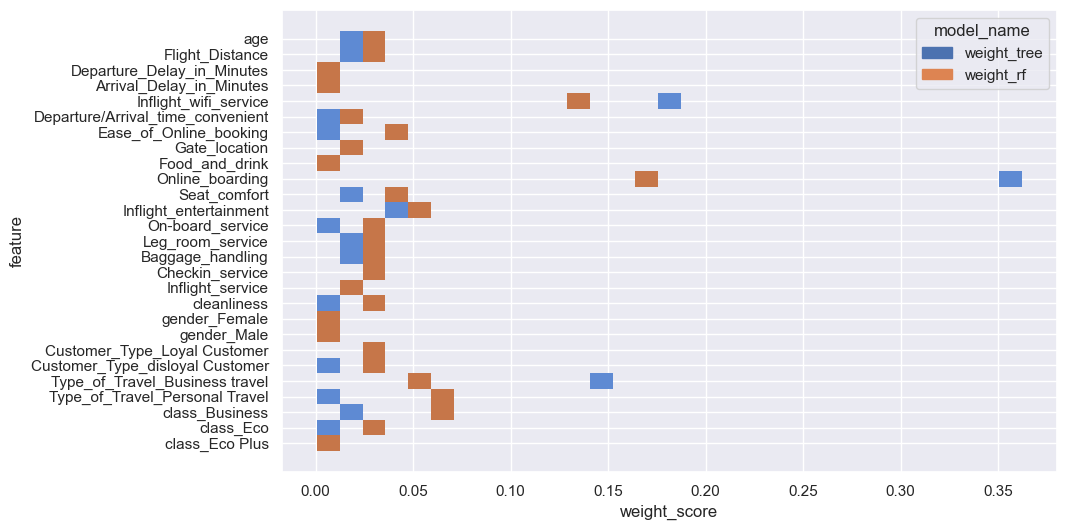

In [68]:
# Гистограмма
plt.figure(figsize=(10, 6))
sns.histplot(data=long_df, x='weight_score', y='feature' ,hue='model_name')
plt.show()

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
# не успело вычилисться до дедлайна(

# Вычислим SHAP значения
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_val[:1000])

# Вывод SHAP значений
shap.summary_plot(shap_values, X_val[:1000], plot_type="bar")

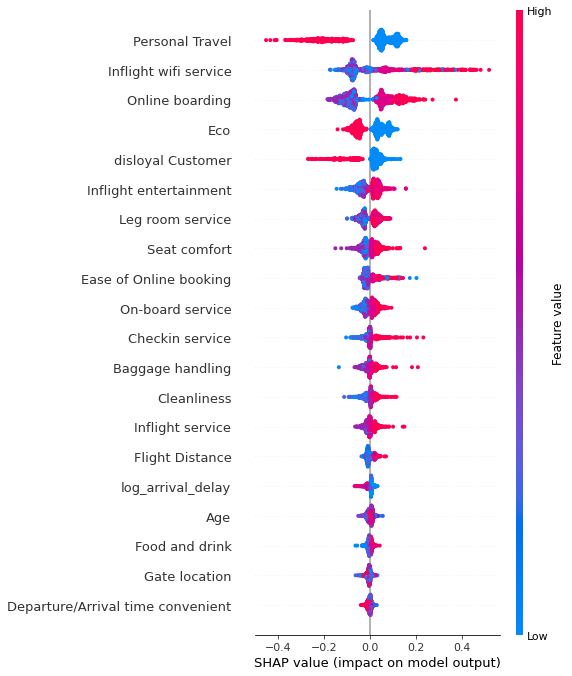

CPU times: user 5min 45s, sys: 2.77 s, total: 5min 47s
Wall time: 5min 45s


In [ ]:
# (•_•)


<font color='#FF6600'>Опишите полученый график</font>

<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below


<font color='#9933CC'>Случайное лес, дающий лучший скор, сохраните в pickle</font>

In [69]:
with open('best_rf_hw3.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?